# DataCollection
This notebook shows how get data from wiseair servers and integrating it with wheater informations coming from ARPA sensors

The final dataset will be indexed by date and time of the measurement done by each sensor. Each row reports information about
* sensor id (pot_id)
* pm1 levels
* pm2p5 levels
* pm4 levels
* pm10 levels
* humidity
* temperature
* wind speed  (from ARPA)
* rain levels (from ARPA)
* latitude
* longitude

Latitude and longitude are refereed to the sensor making the measurement (note: data coming from ARPA are taken with a different and single weather station located at Milano Lambrate, latitude and longitude reported do not refer to this station)

Data need to be hourly aggregated to have equally spaced samples in time before further processing, morover the need for hourly aggregation comes from the fact that ARPA data are given in intervals of one hour, thus data crossing cannot be done if wiseair sensors data and ARPA informations are not aligned.
Using daily average is not recommended because interesting patterns may be lost.

In [1]:
import sys
sys.path.insert(0, '../src/')

from DataCollector import DataCollector
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# graphics settings
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

In [3]:
# COLLECT DATA, THIS REQUIRES TIME... WAIT UNTIL FINISH BEFORE RUNNING NEXT CELLS

dataCollector = DataCollector()

# write a fresh CSV file containing data for the selected period
# avoid to call this function if you already have a dataset, call updateData() instead
BEGIN_DATE = "2020-06-01"
END_DATE   = "2020-10-25"
dataCollector.getData(BEGIN_DATE, END_DATE, "../data/tsData.csv")

# automatically update dataset with data up to yesterday
# dataCollector.updateData("data.csv")

fetching data from Wiseair server
progress [################################################################################] 100.0%
got not null data from 68 sensors                                                                                                    
data stored in ../data/tsData.csv


In [187]:
data = pd.read_csv("../data/tsData.csv")
data["created_at"] = pd.to_datetime(data["created_at"])
data.set_index("created_at", inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 186820 entries, 2020-06-24 17:00:00 to 2020-11-04 23:00:00
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pot_id           186820 non-null  int64  
 1   pm1SPS           121423 non-null  float64
 2   pm2p5SPS         121423 non-null  float64
 3   pm4SPS           121423 non-null  float64
 4   pm10SPS          121423 non-null  float64
 5   temperature_sht  121423 non-null  float64
 6   humidity_sht     121423 non-null  float64
 7   latitude         186820 non-null  float64
 8   longitude        186820 non-null  float64
 9   wind             186820 non-null  float64
 10  rain             186820 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 17.1 MB


In [188]:
# group data on base of sensors id
groupedData = data.groupby('pot_id', as_index=False)

averagedData = pd.DataFrame()
potID = set(data['pot_id'])

# average data by sensor id
for y in potID:
    tmp = groupedData.get_group(y).resample('H').mean()
    tmp['pot_id'] = tmp['pot_id'].fillna(y)
    tmp['latitude'] = tmp['latitude'].fillna(method = "ffill")
    tmp['longitude'] = tmp['longitude'].fillna(method = "ffill")
    averagedData = pd.concat([averagedData, tmp])

# recast pot_id to integer
averagedData['pot_id'] = averagedData['pot_id'].astype(int)

averagedData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude,wind,rain
created_at,,,,,,,,,,,
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,45.458286,9.16756,2.0,0.0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,45.458286,9.16756,1.8,0.0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,45.458286,9.16756,1.7,0.0
2020-06-24 20:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756,1.4,0.0
2020-06-24 21:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756,2.0,0.0


In [4]:
data=averagedData
data.head()

""


In [7]:
# keep only interesting features
interesting = ["pm1SPS", "pm2p5SPS", "pm4SPS", "pm10SPS", "temperature_sht", "humidity_sht", 
               "pot_id", "lat", "lon"]

for feature in list(data.columns.values):
    if feature not in interesting:
        data.drop(feature, axis = 1, inplace = True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 186820 entries, 2020-06-24 17:00:00 to 2020-11-04 23:00:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pot_id           186820 non-null  int64  
 1   pm1SPS           121423 non-null  float64
 2   pm2p5SPS         121423 non-null  float64
 3   pm4SPS           121423 non-null  float64
 4   pm10SPS          121423 non-null  float64
 5   temperature_sht  121423 non-null  float64
 6   humidity_sht     121423 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 11.4 MB


In [9]:
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

In [10]:
finalData=data.dropna()

In [11]:
finalData['pm2p5SPS'].autocorr()

0.9406824292484843

In [12]:
finalData['pm4SPS'].autocorr()

0.9362494869277929

In [13]:
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [14]:
dati=finalData.loc[finalData['pot_id'] == 1024]

In [15]:
interesting2 = ["pm1SPS", "pm2p5SPS", "pm4SPS", "pm10SPS", "temperature_sht", "humidity_sht"]

for feature in list(dati.columns.values):
    if feature not in interesting2:
        dati.drop(feature, axis = 1, inplace = True)

        
dati

,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht
created_at,,,,,,
2020-06-24 17:00:00,7.028750,7.625000,7.502500,7.508750,35.715000,32.99125
2020-06-24 18:00:00,5.527500,6.083333,6.405833,6.456667,35.633333,34.51250
2020-06-24 19:00:00,5.917500,6.625000,6.907500,6.965000,34.972500,31.95875
2020-06-25 00:00:00,4.531000,5.400000,5.660000,5.737000,30.809000,32.37100
2020-06-25 01:00:00,3.310000,4.000000,4.390000,4.470000,28.210000,34.16000
...,...,...,...,...,...,...
2020-11-04 19:00:00,41.666667,40.666667,53.163333,53.976667,19.680000,70.00000
2020-11-04 20:00:00,45.200000,43.000000,54.803333,55.426667,21.246667,70.00000
2020-11-04 21:00:00,49.075000,47.000000,61.235000,62.070000,21.815000,70.00000


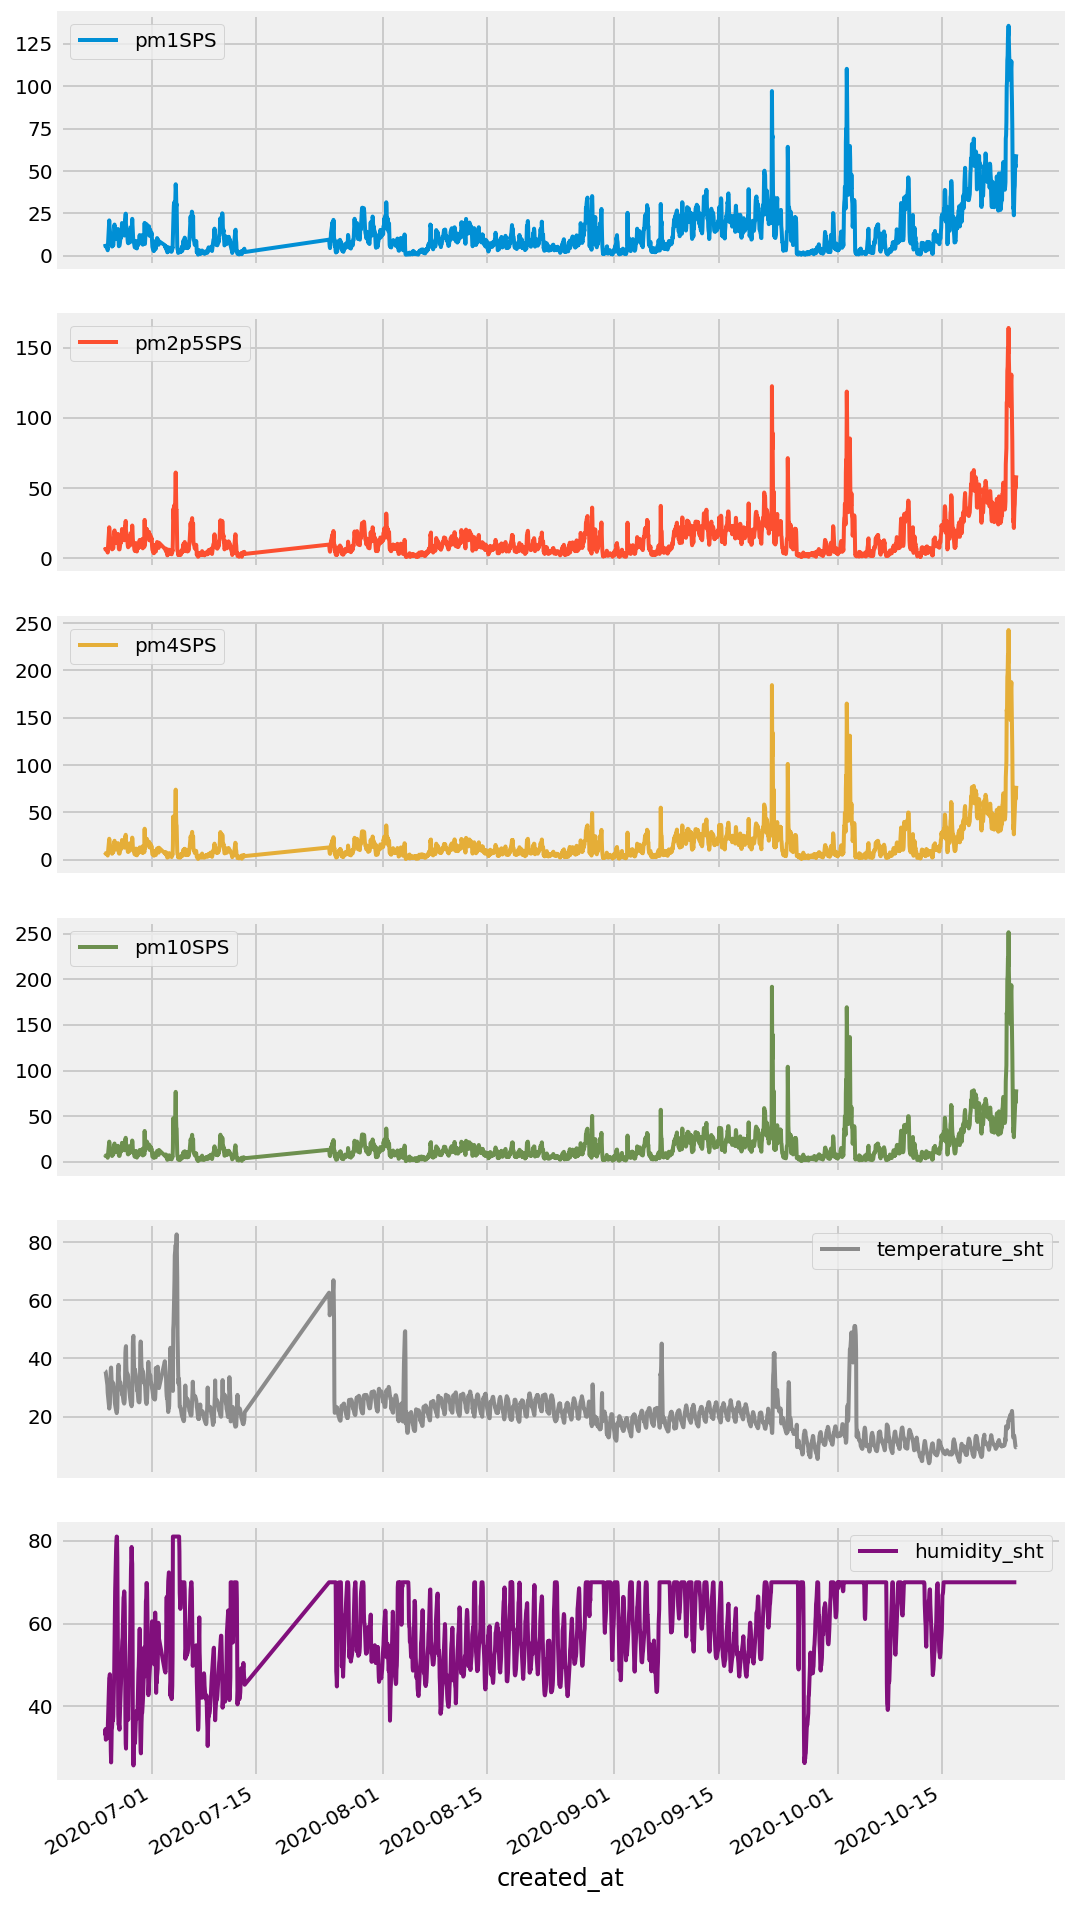

In [122]:
dati.plot(subplots=True, figsize=(8,18));

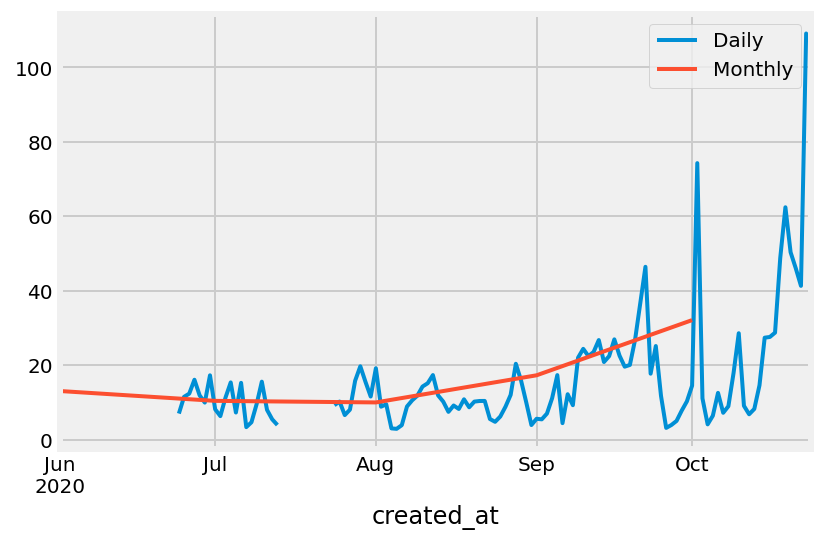

In [165]:
dati_monthly = dati.resample('M').mean()
dati_dayly = dati.resample('D').mean()
dati_dayly.pm10SPS.plot(label="Daily")
dati_monthly.pm10SPS.plot(label="Monthly")

plt.legend();

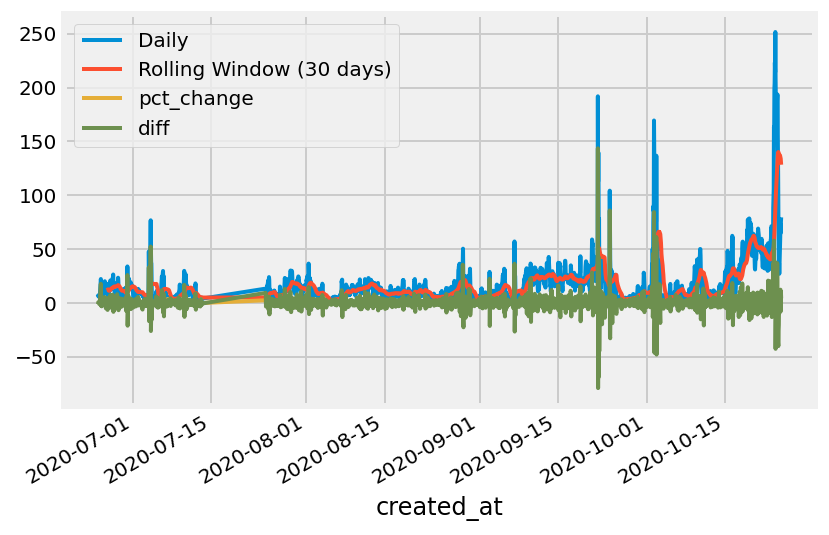

In [188]:
dati['Close Rolling Window'] = dati['pm10SPS'].rolling(window=30).mean()
dati.pm10SPS.plot(label="Daily")
dati['Close Rolling Window'].plot(label="Rolling Window (30 days)")
dati.pm10SPS.pct_change().plot(label="pct_change")
dati.pm10SPS.diff().plot(label="diff")
plt.legend();

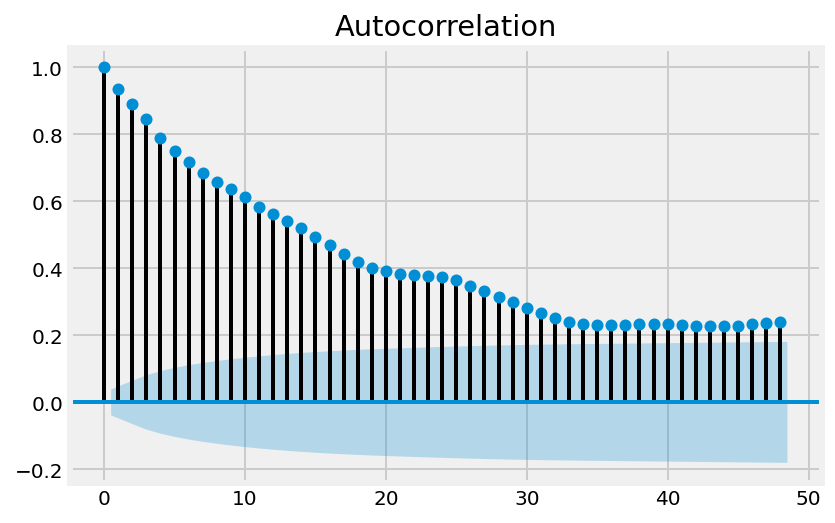

In [190]:
plot_acf(dati['pm10SPS'],lags=48)
plt.show()

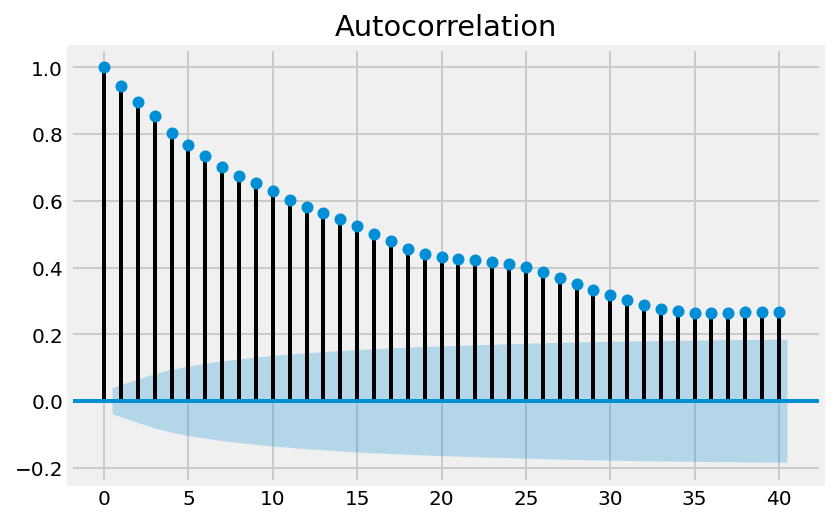

In [116]:
plot_acf(dati['pm2p5SPS'],lags=40)
plt.show()

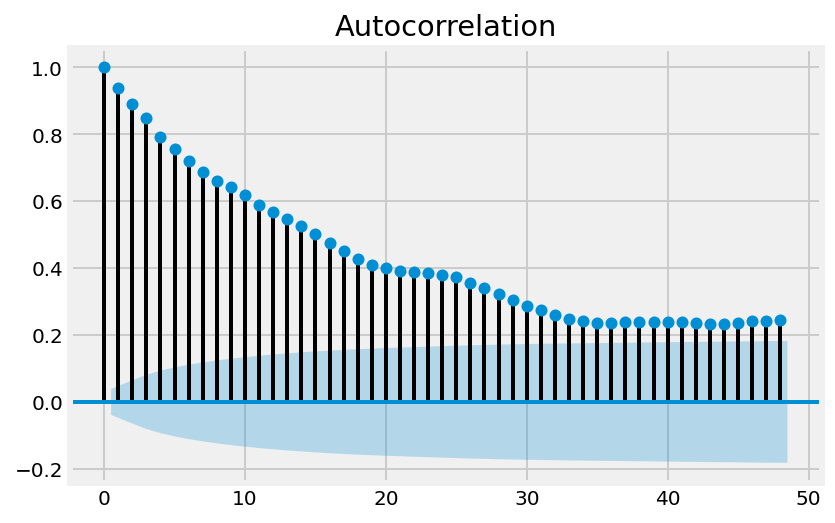

In [117]:
plot_acf(dati['pm4SPS'],lags=48)
plt.show()

In [118]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(dati['pm10SPS'])
print("p-value of pm10SPS: %.4f"%adf[1])
adf = adfuller(dati['pm2p5SPS'])
print("p-value of pm2p5SPS: %.4f"%adf[1])
adf = adfuller(dati['pm4SPS'])
print("p-value of pm4SPS: %.4f"%adf[1])


p-value of pm10SPS: 0.0031
p-value of pm2p5SPS: 0.0029
p-value of pm4SPS: 0.0032


pm10SPS,pm2p5SPS and pm4SPS have p-value which are less than than 0.05, null hypothesis that the series is random walk it is rejected (with 95% confidence level this is not a random walk). This means that we can reject the hypothesis that the series is non-stationary.  

# AR MODELS

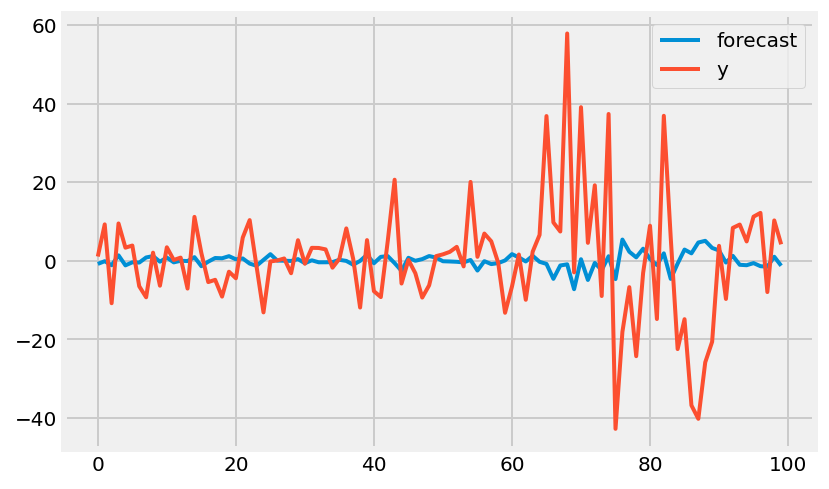

In [124]:
from statsmodels.tsa.arima_model import ARMA
pm10_model = ARMA(dati['pm10SPS'].diff().iloc[1:].values, order=(1,0))
pm10_result = pm10_model.fit()
pm10_result.plot_predict(start=-100)
plt.show()


In [191]:
rmse = math.sqrt(mean_squared_error(dati['pm10SPS'].diff().iloc[900:1000].values, pm10_result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)

The root mean squared error is 2.636


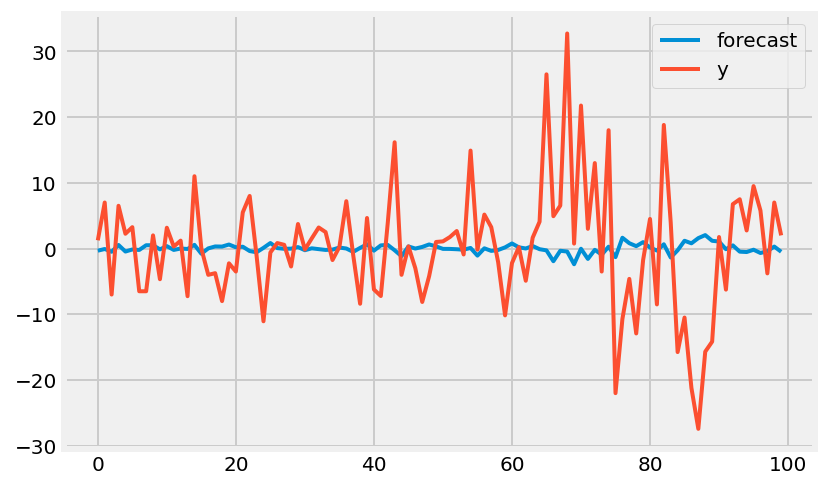

The root mean squared error is 1.905


In [127]:
pm2p5_model = ARMA(dati['pm2p5SPS'].diff().iloc[1:].values, order=(1,0))
pm2p5_result = pm2p5_model.fit()
pm2p5_result.plot_predict(start=-100)
plt.show()
rmse = math.sqrt(mean_squared_error(dati['pm2p5SPS'].diff().iloc[900:1000].values, pm2p5_result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)

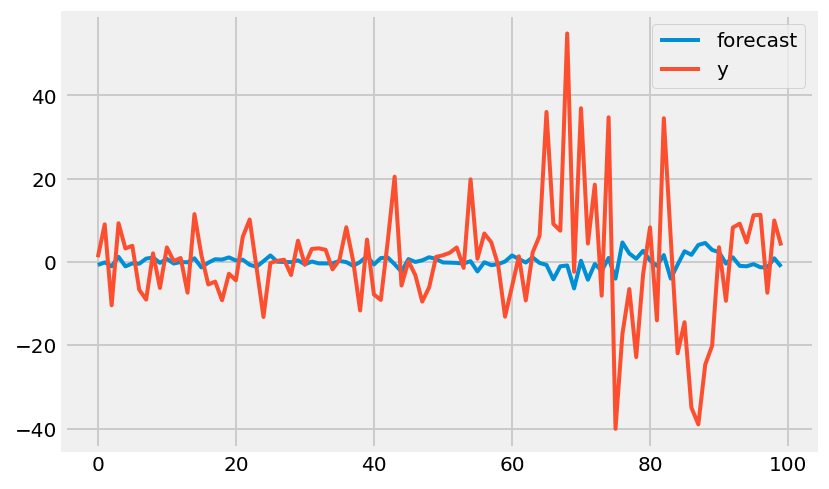

The root mean squared error is 2.556


In [129]:
pm4_model = ARMA(dati['pm4SPS'].diff().iloc[1:].values, order=(1,0))
pm4_result = pm4_model.fit()
pm4_result.plot_predict(start=-100)
plt.show()
rmse = math.sqrt(mean_squared_error(dati['pm4SPS'].diff().iloc[900:1000].values, pm4_result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)

# ARMA MODELS

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2546
Model:                     ARMA(3, 2)   Log Likelihood               -8700.535
Method:                       css-mle   S.D. of innovations              7.377
Date:                Sun, 08 Nov 2020   AIC                          17415.070
Time:                        16:22:53   BIC                          17455.966
Sample:                             0   HQIC                         17429.903
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0279      0.138      0.203      0.839      -0.242       0.298
ar.L1.y       -0.4381      0.059     -7.477      0.000      -0.553      -0.323
ar.L2.y       -0.8114      0.053    -15.237      0.0

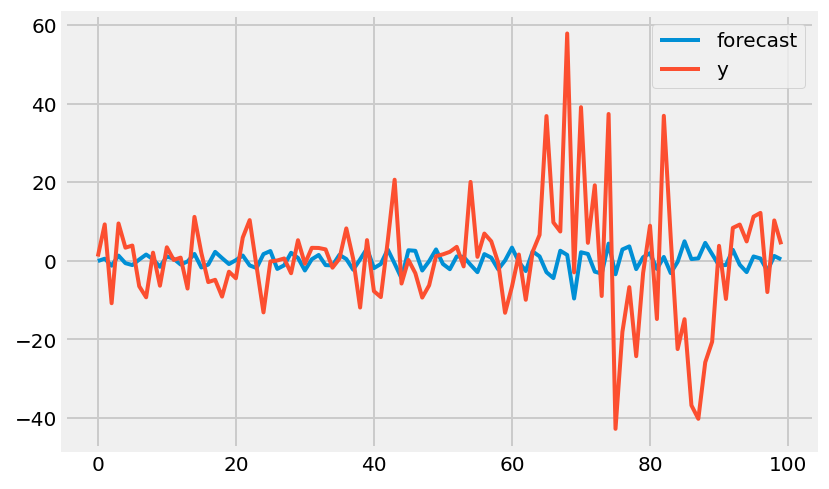

In [130]:
ARMAmodel= ARMA(dati['pm10SPS'].diff().iloc[1:].values, order=(3,2))
ARMAresult = ARMAmodel.fit()
print(ARMAresult.summary())
print("μ=%.3f, ϕ1=%.3f, θ1=%.3f"%(ARMAresult.params[0],ARMAresult.params[1],ARMAresult.params[2]))
ARMAresult.plot_predict(start=-100)
plt.show()

In [131]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(dati['pm10SPS'],order=(1,0,1))
arima_results = arima_model.fit()
arima_results.summary()

C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                pm10SPS   No. Observations:                 2547
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8715.228
Date:                Sun, 08 Nov 2020   AIC                          17436.456
Time:                        16:23:05   BIC                          17453.984
Sample:                             0   HQIC                         17442.814
                               - 2547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9720      0.002    561.529      0.000       0.969       0.975
ma.L1         -0.1149      0.005    -21.932      0.000      -0.125      -0.105
sigma2        54.8497      0.234    234.431      0.000      54.391      55.308
===================================================================================
Ljung-Box (Q):                      154.72   Jarque-Bera (JB):            859524.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.59   Skew:                             4.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        92.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
arima_prediction = arima_results.get_prediction()
arima_mean_prediction = arima_prediction.predicted_mean
confidence_intervals = arima_prediction.conf_int()
lower_limits = confidence_intervals['lower pm10SPS']
upper_limits = confidence_intervals['upper pm10SPS']

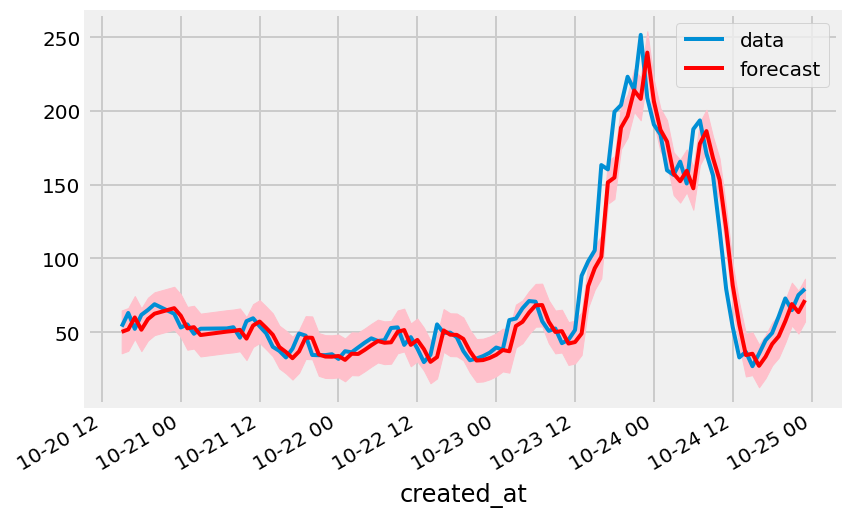

In [137]:
plt.figure()
# Plot prediction
plt.plot(dati['pm10SPS'][-100:],label='data')
arima_mean_prediction[-100:].plot(color='red', label='forecast')
#plt.plot(arima_mean_prediction.index, arima_mean_prediction, color='red', label='forecast')
plt.fill_between(arima_mean_prediction.index[-100:], lower_limits[-100:],upper_limits[-100:], color='pink')
plt.legend()
plt.show()

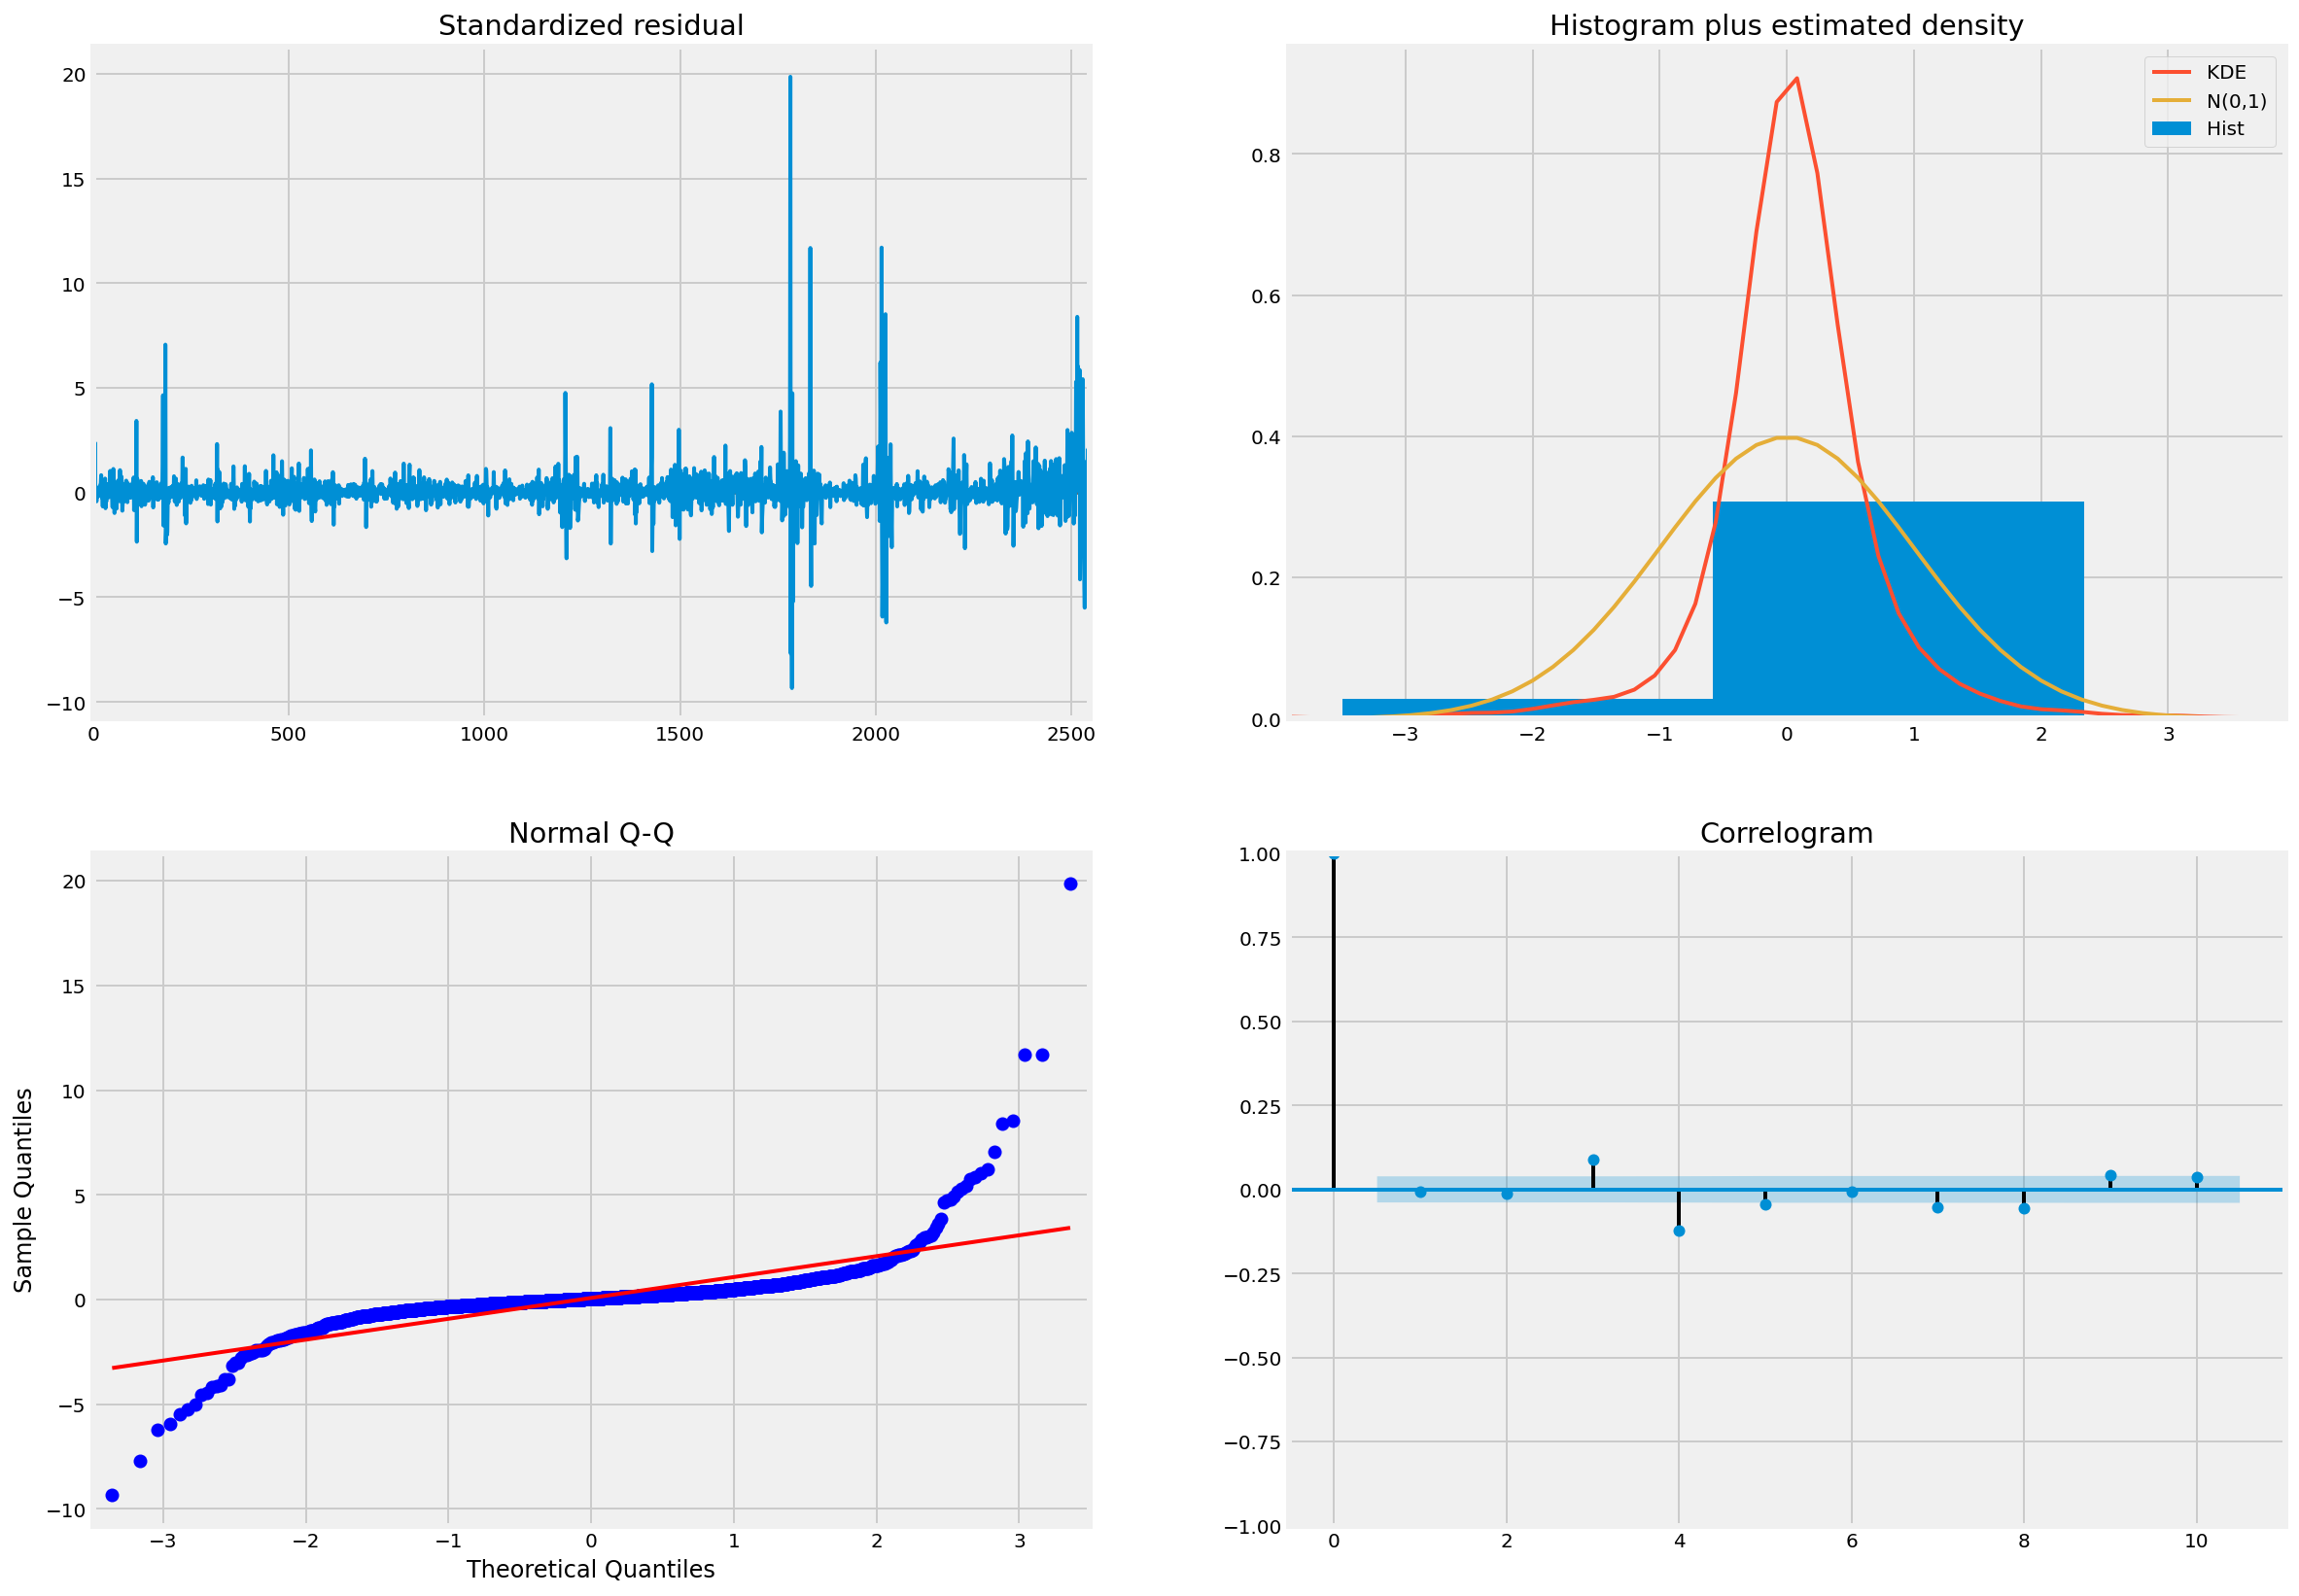

In [138]:
g = arima_results.plot_diagnostics(figsize=(18,14));


The histogram is not normally distributed, in addition KDE and N(0,1) should basically overlap but they don't. The correlogram shows some peaks for some lags suggesting that the model is not capturing all the information of the series and some is still contained in the residuals.

C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated 

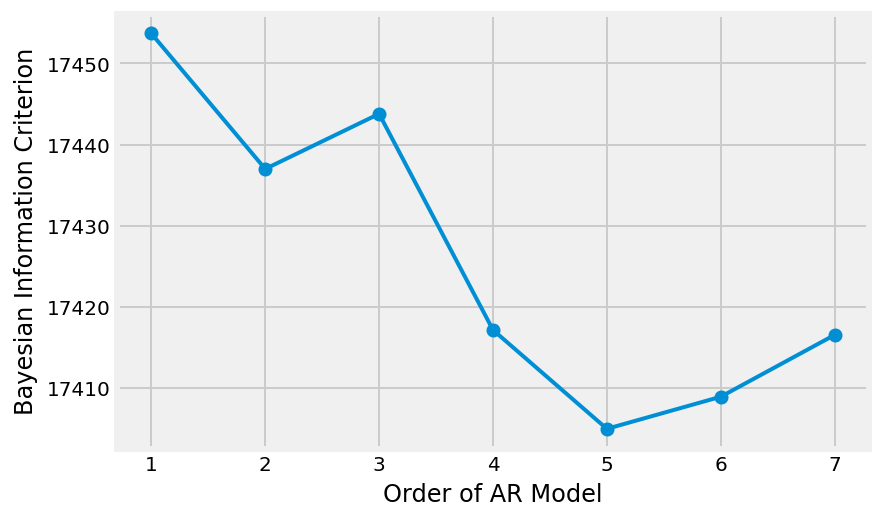

In [139]:
max_model_order = 8
BIC = np.zeros(max_model_order)
AIC = np.zeros(max_model_order)
for ar_order in range(max_model_order):
    model = ARMA(dati['pm10SPS'], order=(ar_order,0))
    result = model.fit()
    
    BIC[ar_order] = result.bic
    AIC[ar_order] = result.aic
    
plt.plot(range(1,max_model_order), BIC[1:max_model_order], marker='o')
plt.xlabel('Order of AR Model');
plt.ylabel('Bayesian Information Criterion');
plt.show()

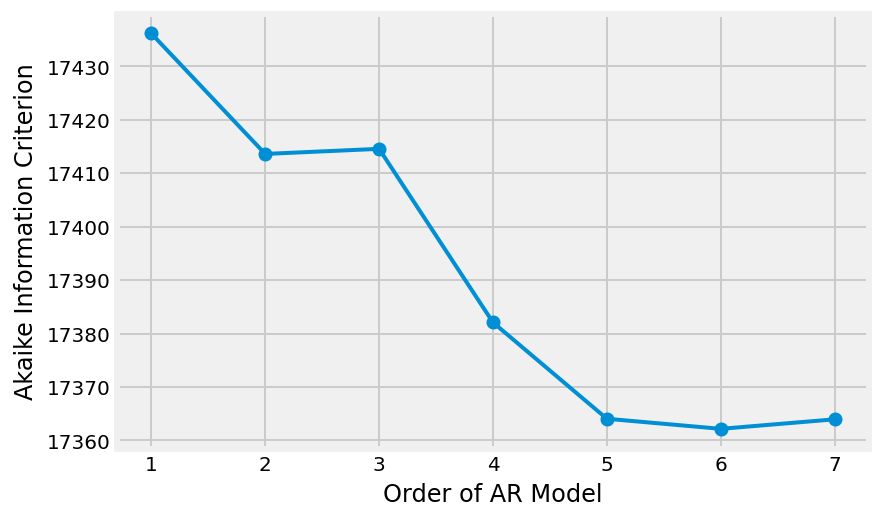

In [140]:
plt.plot(range(1,max_model_order), AIC[1:max_model_order], marker='o')
plt.xlabel('Order of AR Model');
plt.ylabel('Akaike Information Criterion');
plt.show()

According to BIC we should choose 5, according to AIC we should choose 6. We choose AIC because is better than BIC to make prevision.


In [196]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(dati['pm10SPS'],order=(6,1,1))
arima_results = arima_model.fit()
arima_results.summary()

C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\neg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                pm10SPS   No. Observations:                 2547
Model:               SARIMAX(6, 1, 1)   Log Likelihood               -8660.083
Date:                Sun, 08 Nov 2020   AIC                          17336.167
Time:                        17:31:38   BIC                          17382.905
Sample:                             0   HQIC                         17353.119
                               - 2547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8321      0.007    116.894      0.000       0.818       0.846
ar.L2          0.0826      0.008     10.871      0.000       0.068       0.098
ar.L3          0.1065      0.007     14.380      0.000       0.092       0.121
ar.L4         -0.1929      0.007    -25.795      0.000      -0.208      -0.178
ar.L5          0.0505      0.010      5.276      0.000       0.032       0.069
ar.L6          0.0196      0.008      2.580      0.010       0.005       0.035
ma.L1         -0.9845      0.005   -215.958      0.000      -0.993      -0.976
sigma2        52.7045      0.226    233.442      0.000      52.262      53.147
===================================================================================
Ljung-Box (Q):                       78.97   Jarque-Bera (JB):            913758.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.34   Skew:                             5.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        95.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [197]:
arima_prediction = arima_results.get_prediction()
arima_mean_prediction = arima_prediction.predicted_mean
confidence_intervals = arima_prediction.conf_int()
lower_limits = confidence_intervals['lower pm10SPS']
upper_limits = confidence_intervals['upper pm10SPS']

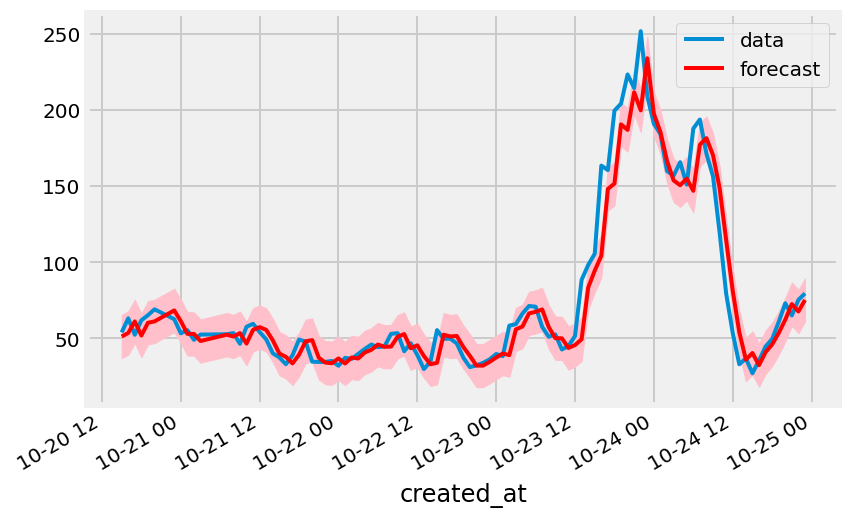

In [198]:
plt.figure()
# Plot prediction
plt.plot(dati['pm10SPS'][-100:],label='data')
arima_mean_prediction[-100:].plot(color='red', label='forecast')
#plt.plot(arima_mean_prediction.index, arima_mean_prediction, color='red', label='forecast')
plt.fill_between(arima_mean_prediction.index[-100:], lower_limits[-100:],upper_limits[-100:], color='pink')
plt.legend()
plt.show()

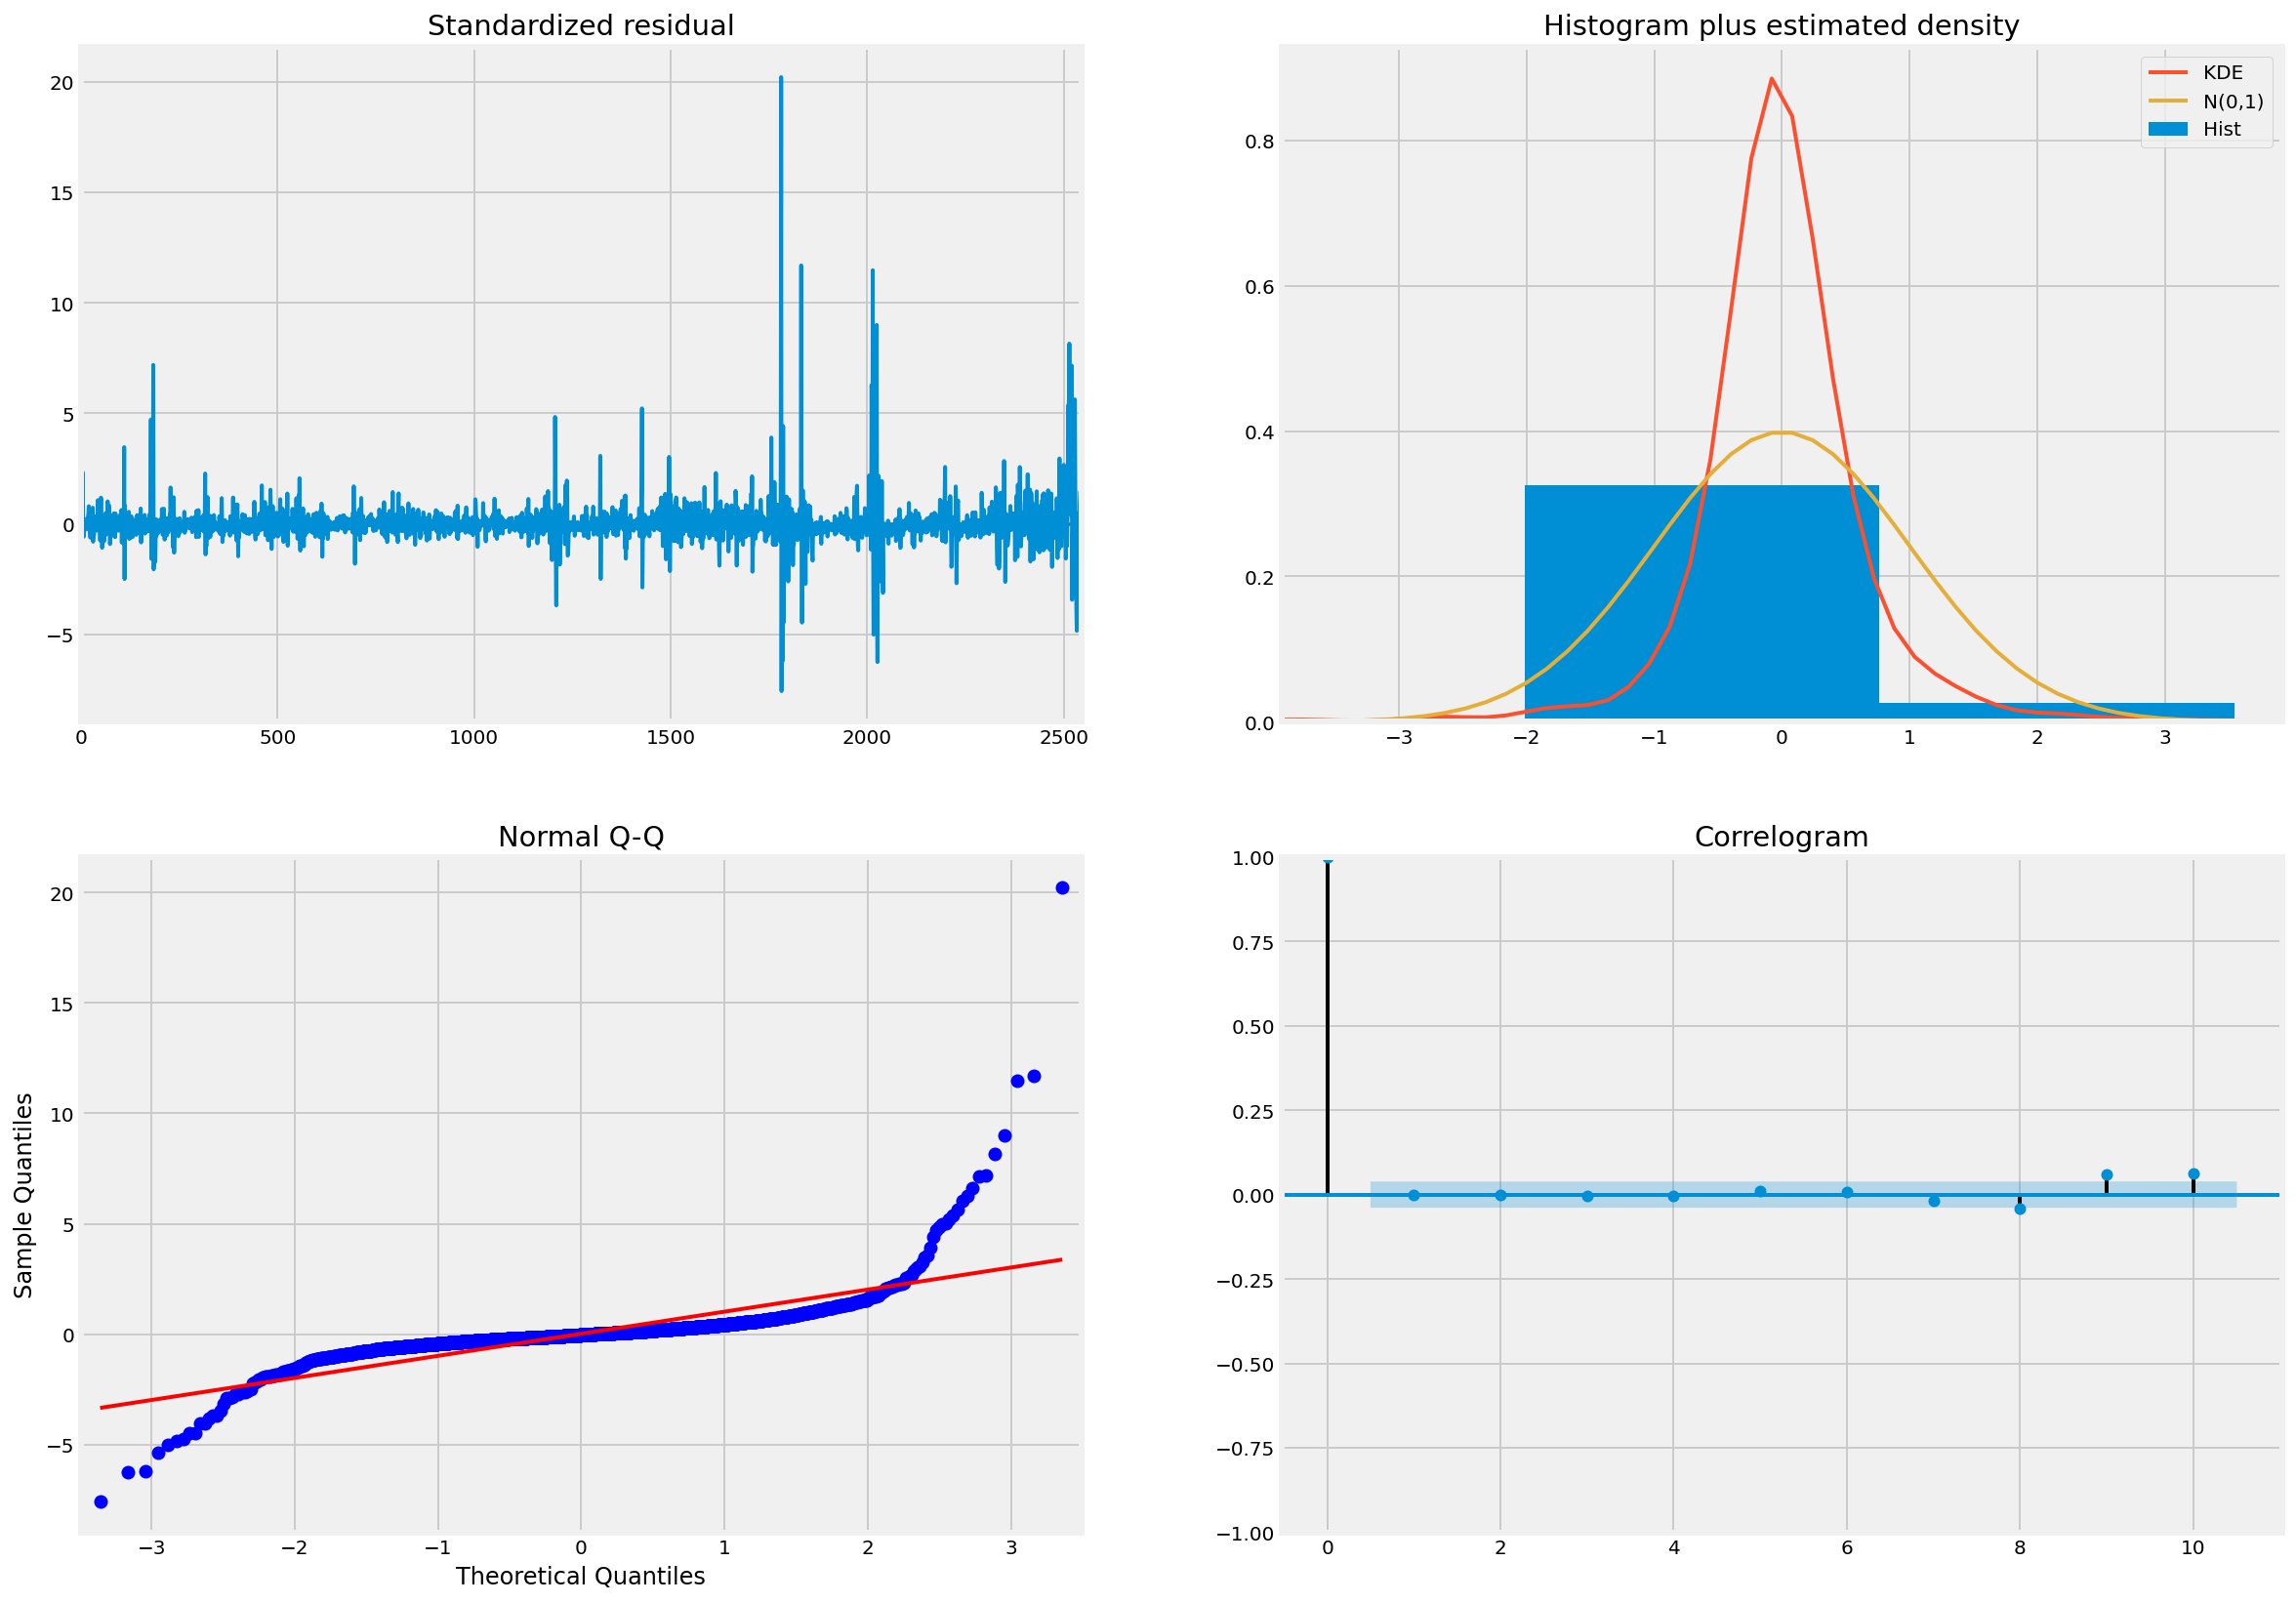

In [199]:
g = arima_results.plot_diagnostics(figsize=(18,14));


Fa un pò schifo comunque :)

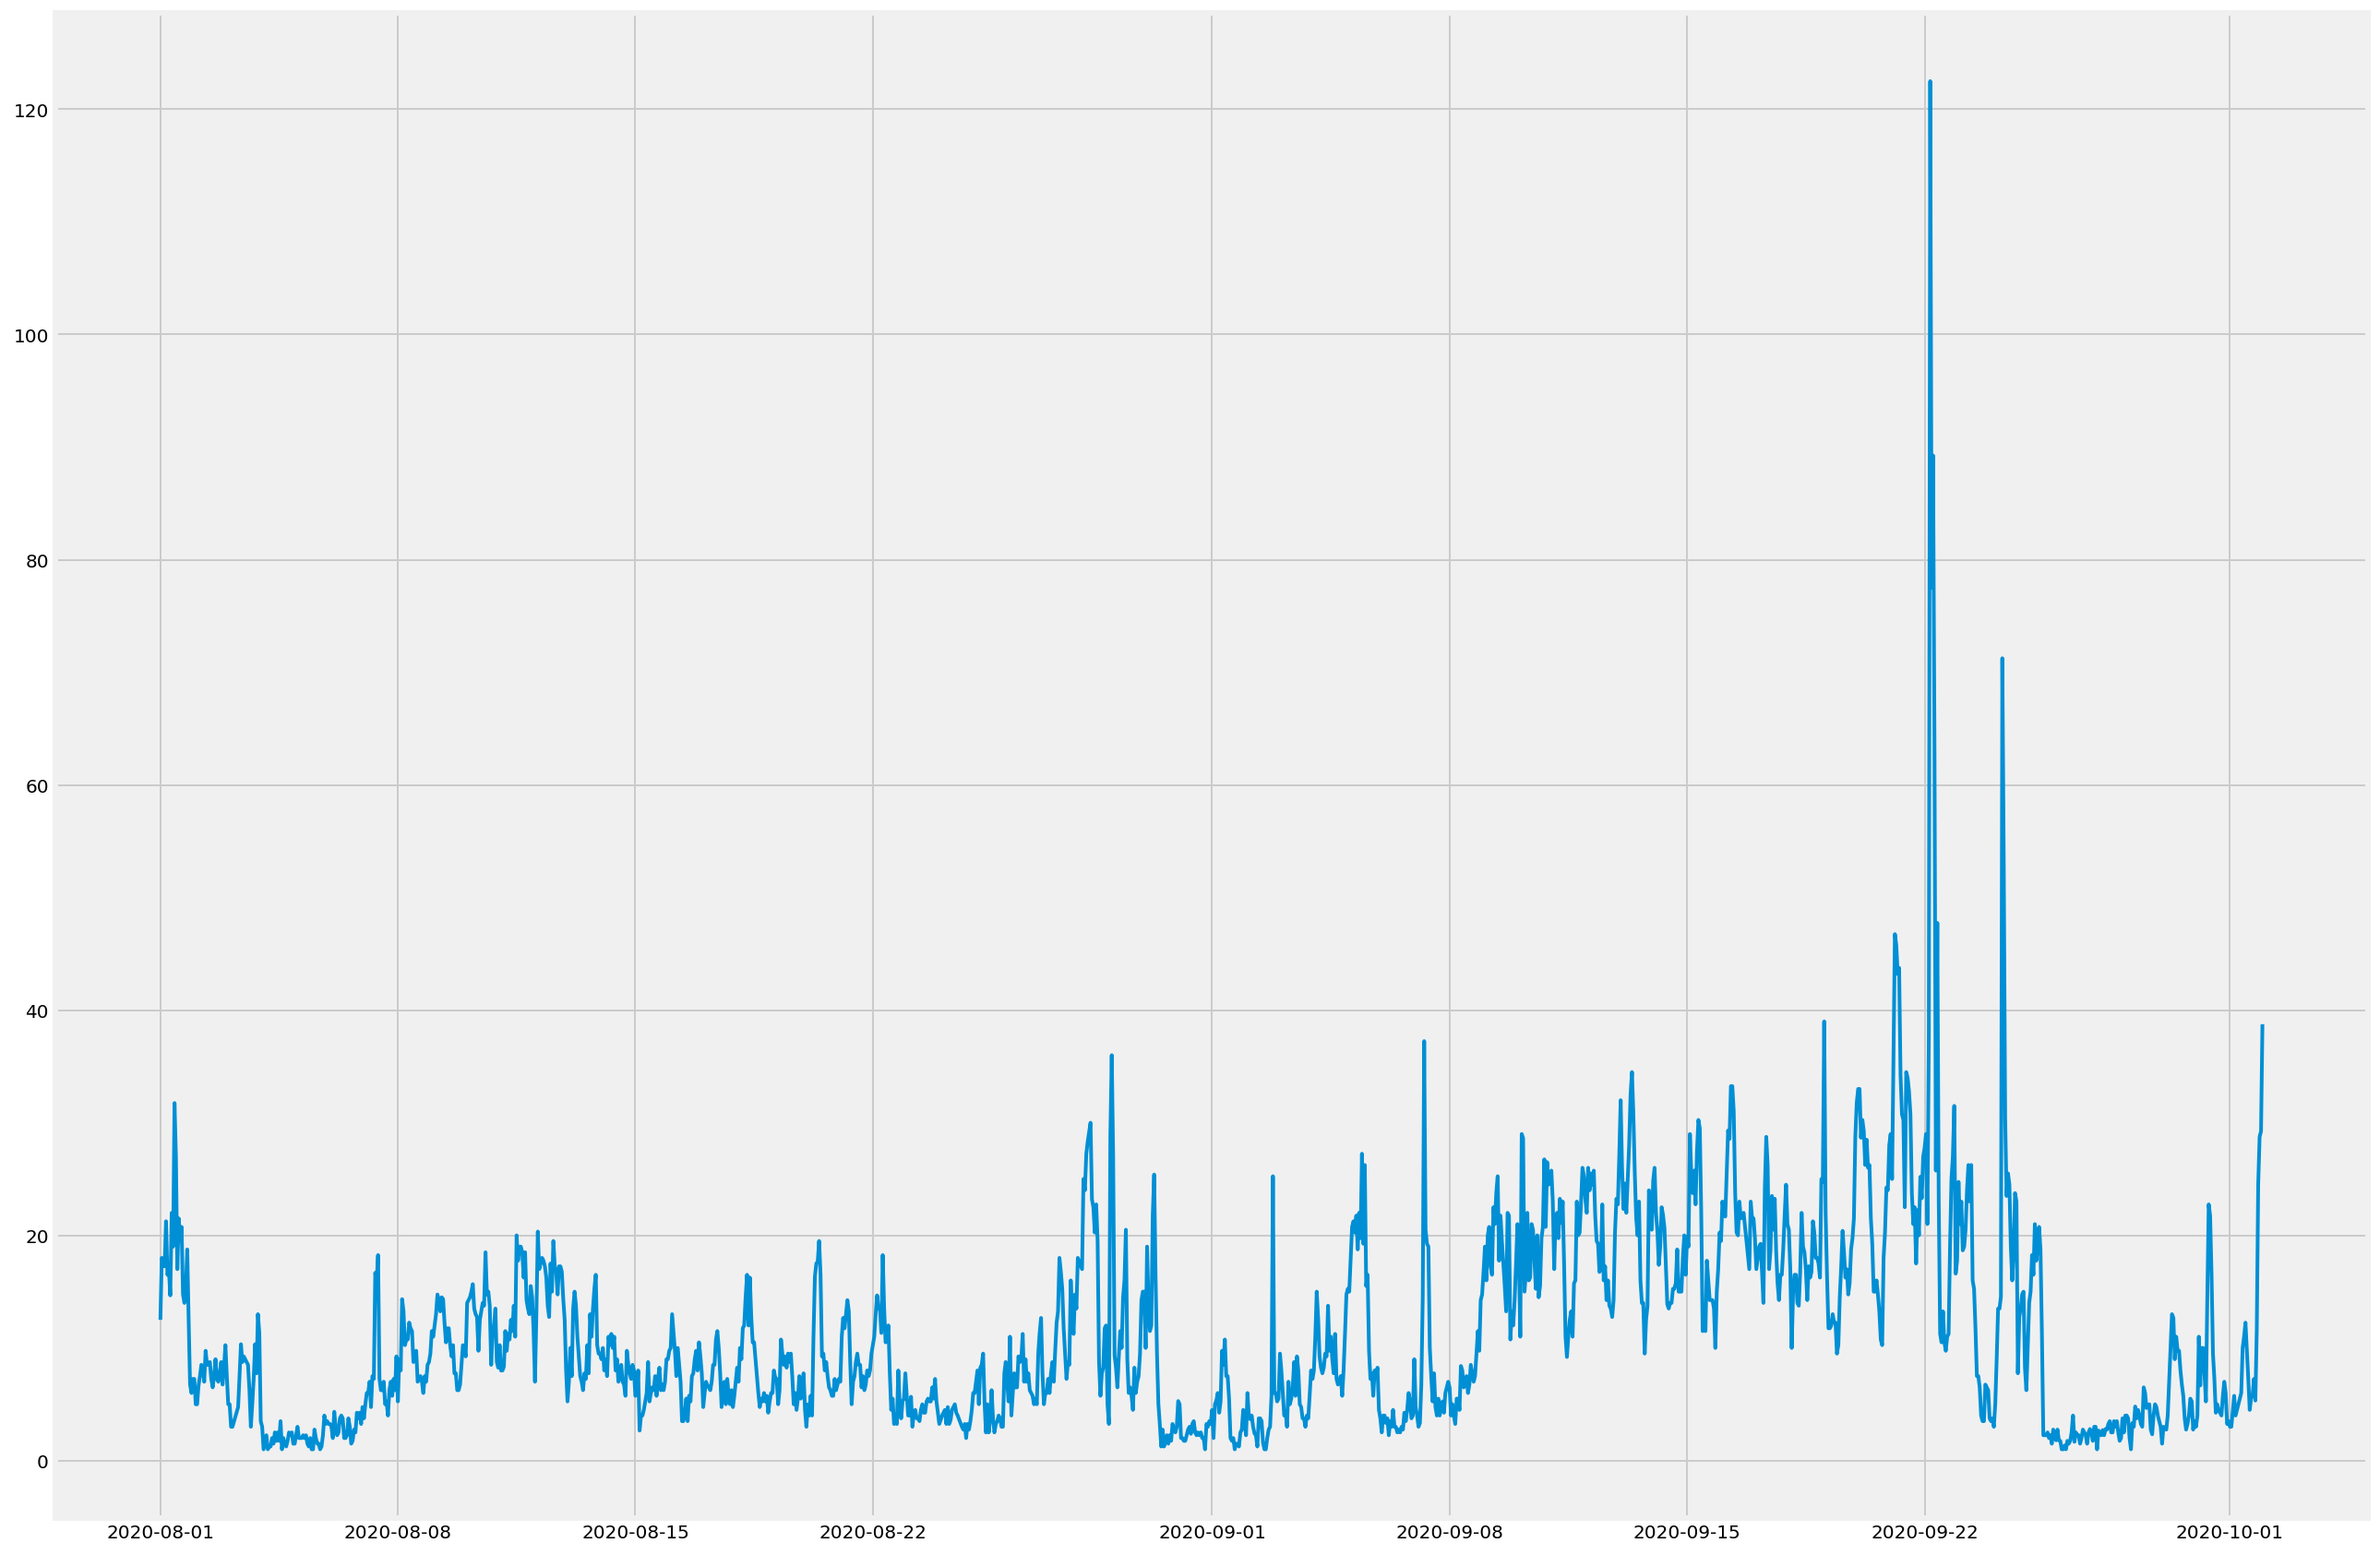

In [48]:
plt.gcf().set_size_inches(20, 15)
plt.plot(dati["pm2p5SPS"]["2020-08-01":"2020-10-01"])
plt.show()

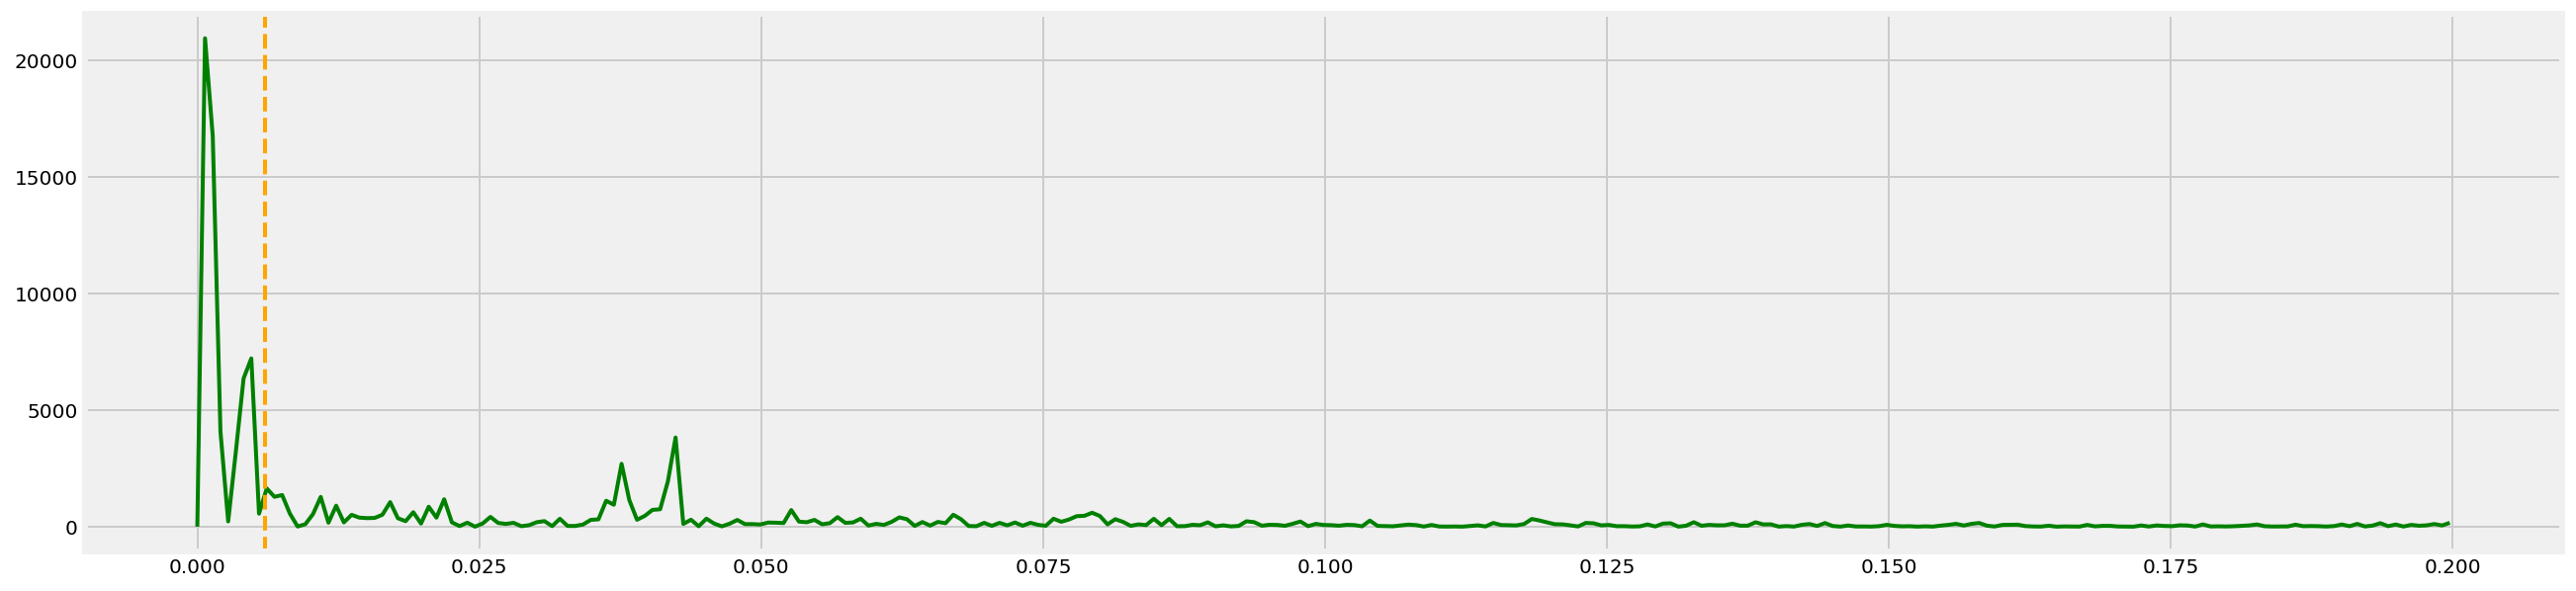

In [126]:
import scipy as sp

f, Pxx_den = sp.signal.periodogram(dati["pm2p5SPS"]["2020-08-01":"2020-10-01"])

r = [freq for freq in f if freq < 0.2]

plt.gcf().set_size_inches(20, 5)
plt.plot(r, Pxx_den[0:len(r)], color="green")
plt.axvline(x=0.006, color="orange", linestyle='dashed')
plt.show()

In [134]:
topFreq = sorted(Pxx_den, reverse=True)[0:6]
d = pd.DataFrame(columns=["power", "freq", "period(hours)", "period(days)"])

for fr in topFreq:
    d = d.append({"power" : fr, 
                  "freq" : f[Pxx_den.tolist().index(fr)], 
                  "period(hours)" : 1/f[Pxx_den.tolist().index(fr)],
                  "period(days)" : (1/f[Pxx_den.tolist().index(fr)])/24}
                  ,ignore_index=True)
d

,power,freq,period(hours),period(days)
0,20936.222356,0.000684,1462.000000,60.916667
1,16743.698519,0.001368,731.000000,30.458333
2,7212.658010,0.004788,208.857143,8.702381
3,6355.784730,0.004104,243.666667,10.152778
4,4071.534812,0.002052,487.333333,20.305556
5,3822.413635,0.042408,23.580645,0.982527


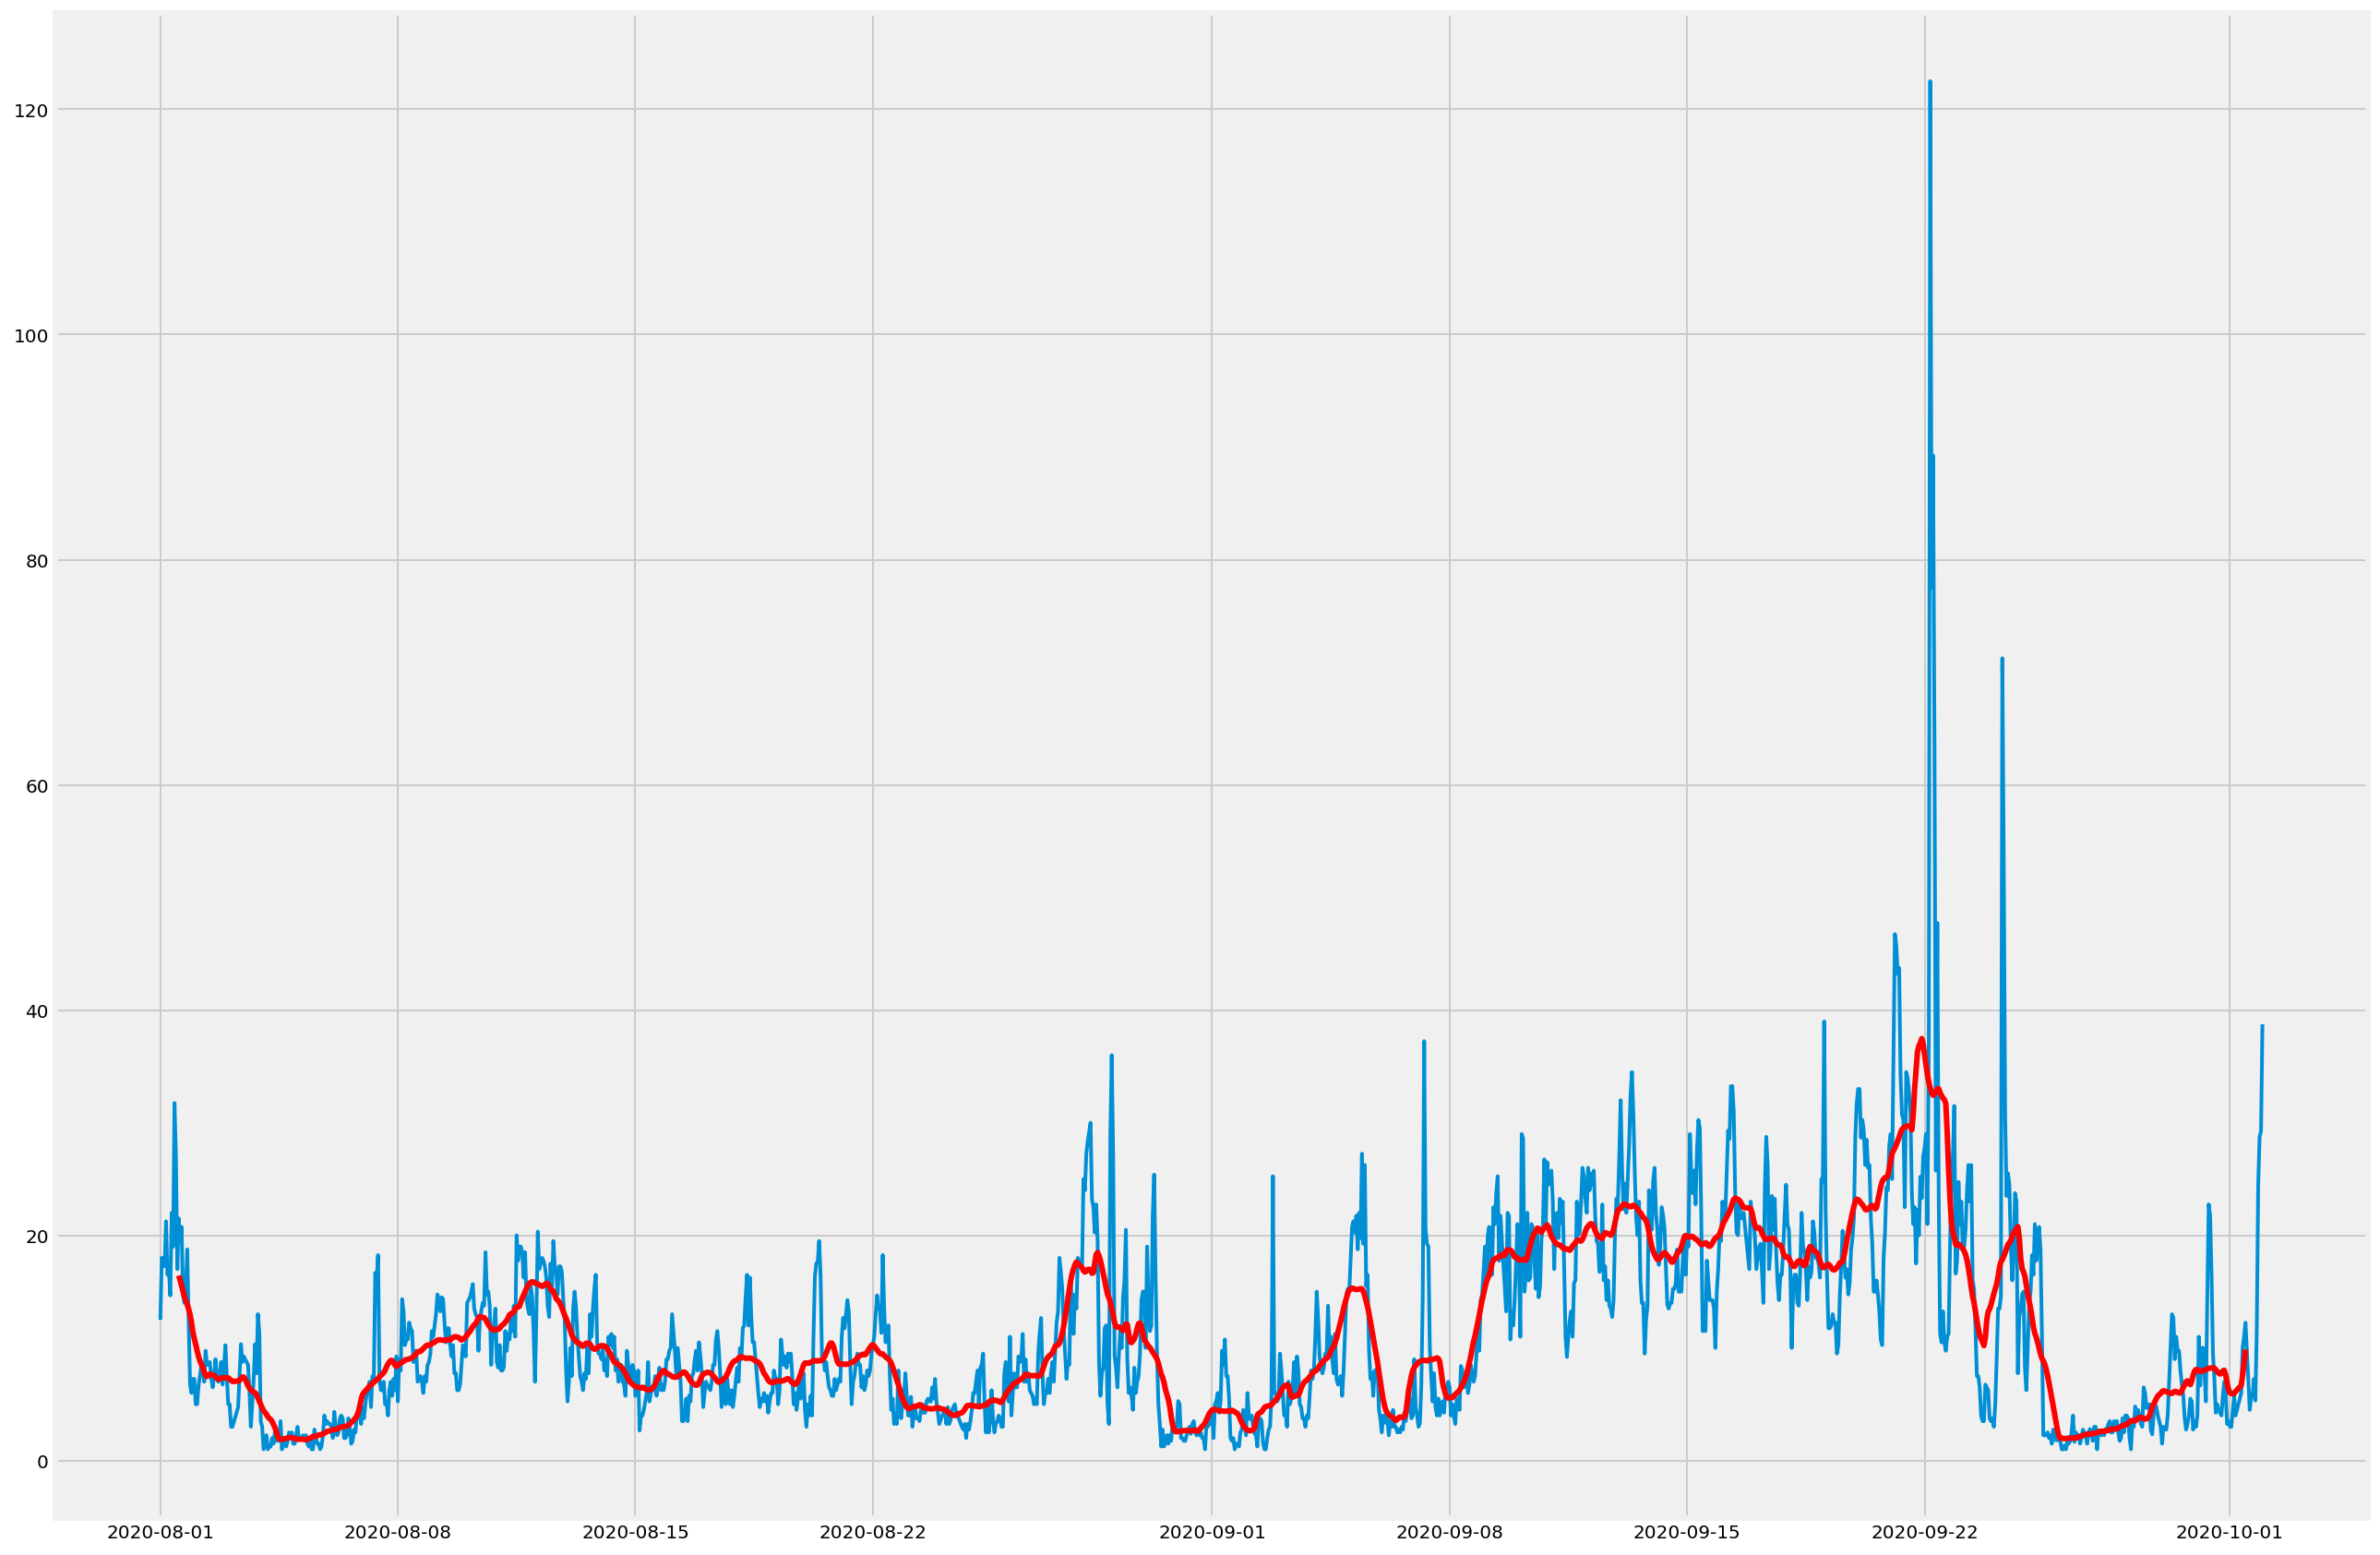

In [133]:
import statsmodels.api as sm
t = dati["pm2p5SPS"]["2020-08-01":"2020-10-01"]

res = sm.tsa.seasonal_decompose(t, freq=24)

plt.gcf().set_size_inches(20, 15)
plt.plot(dati["pm2p5SPS"]["2020-08-01":"2020-10-01"])
plt.plot(res.trend, color="red", linewidth=3)
plt.show()

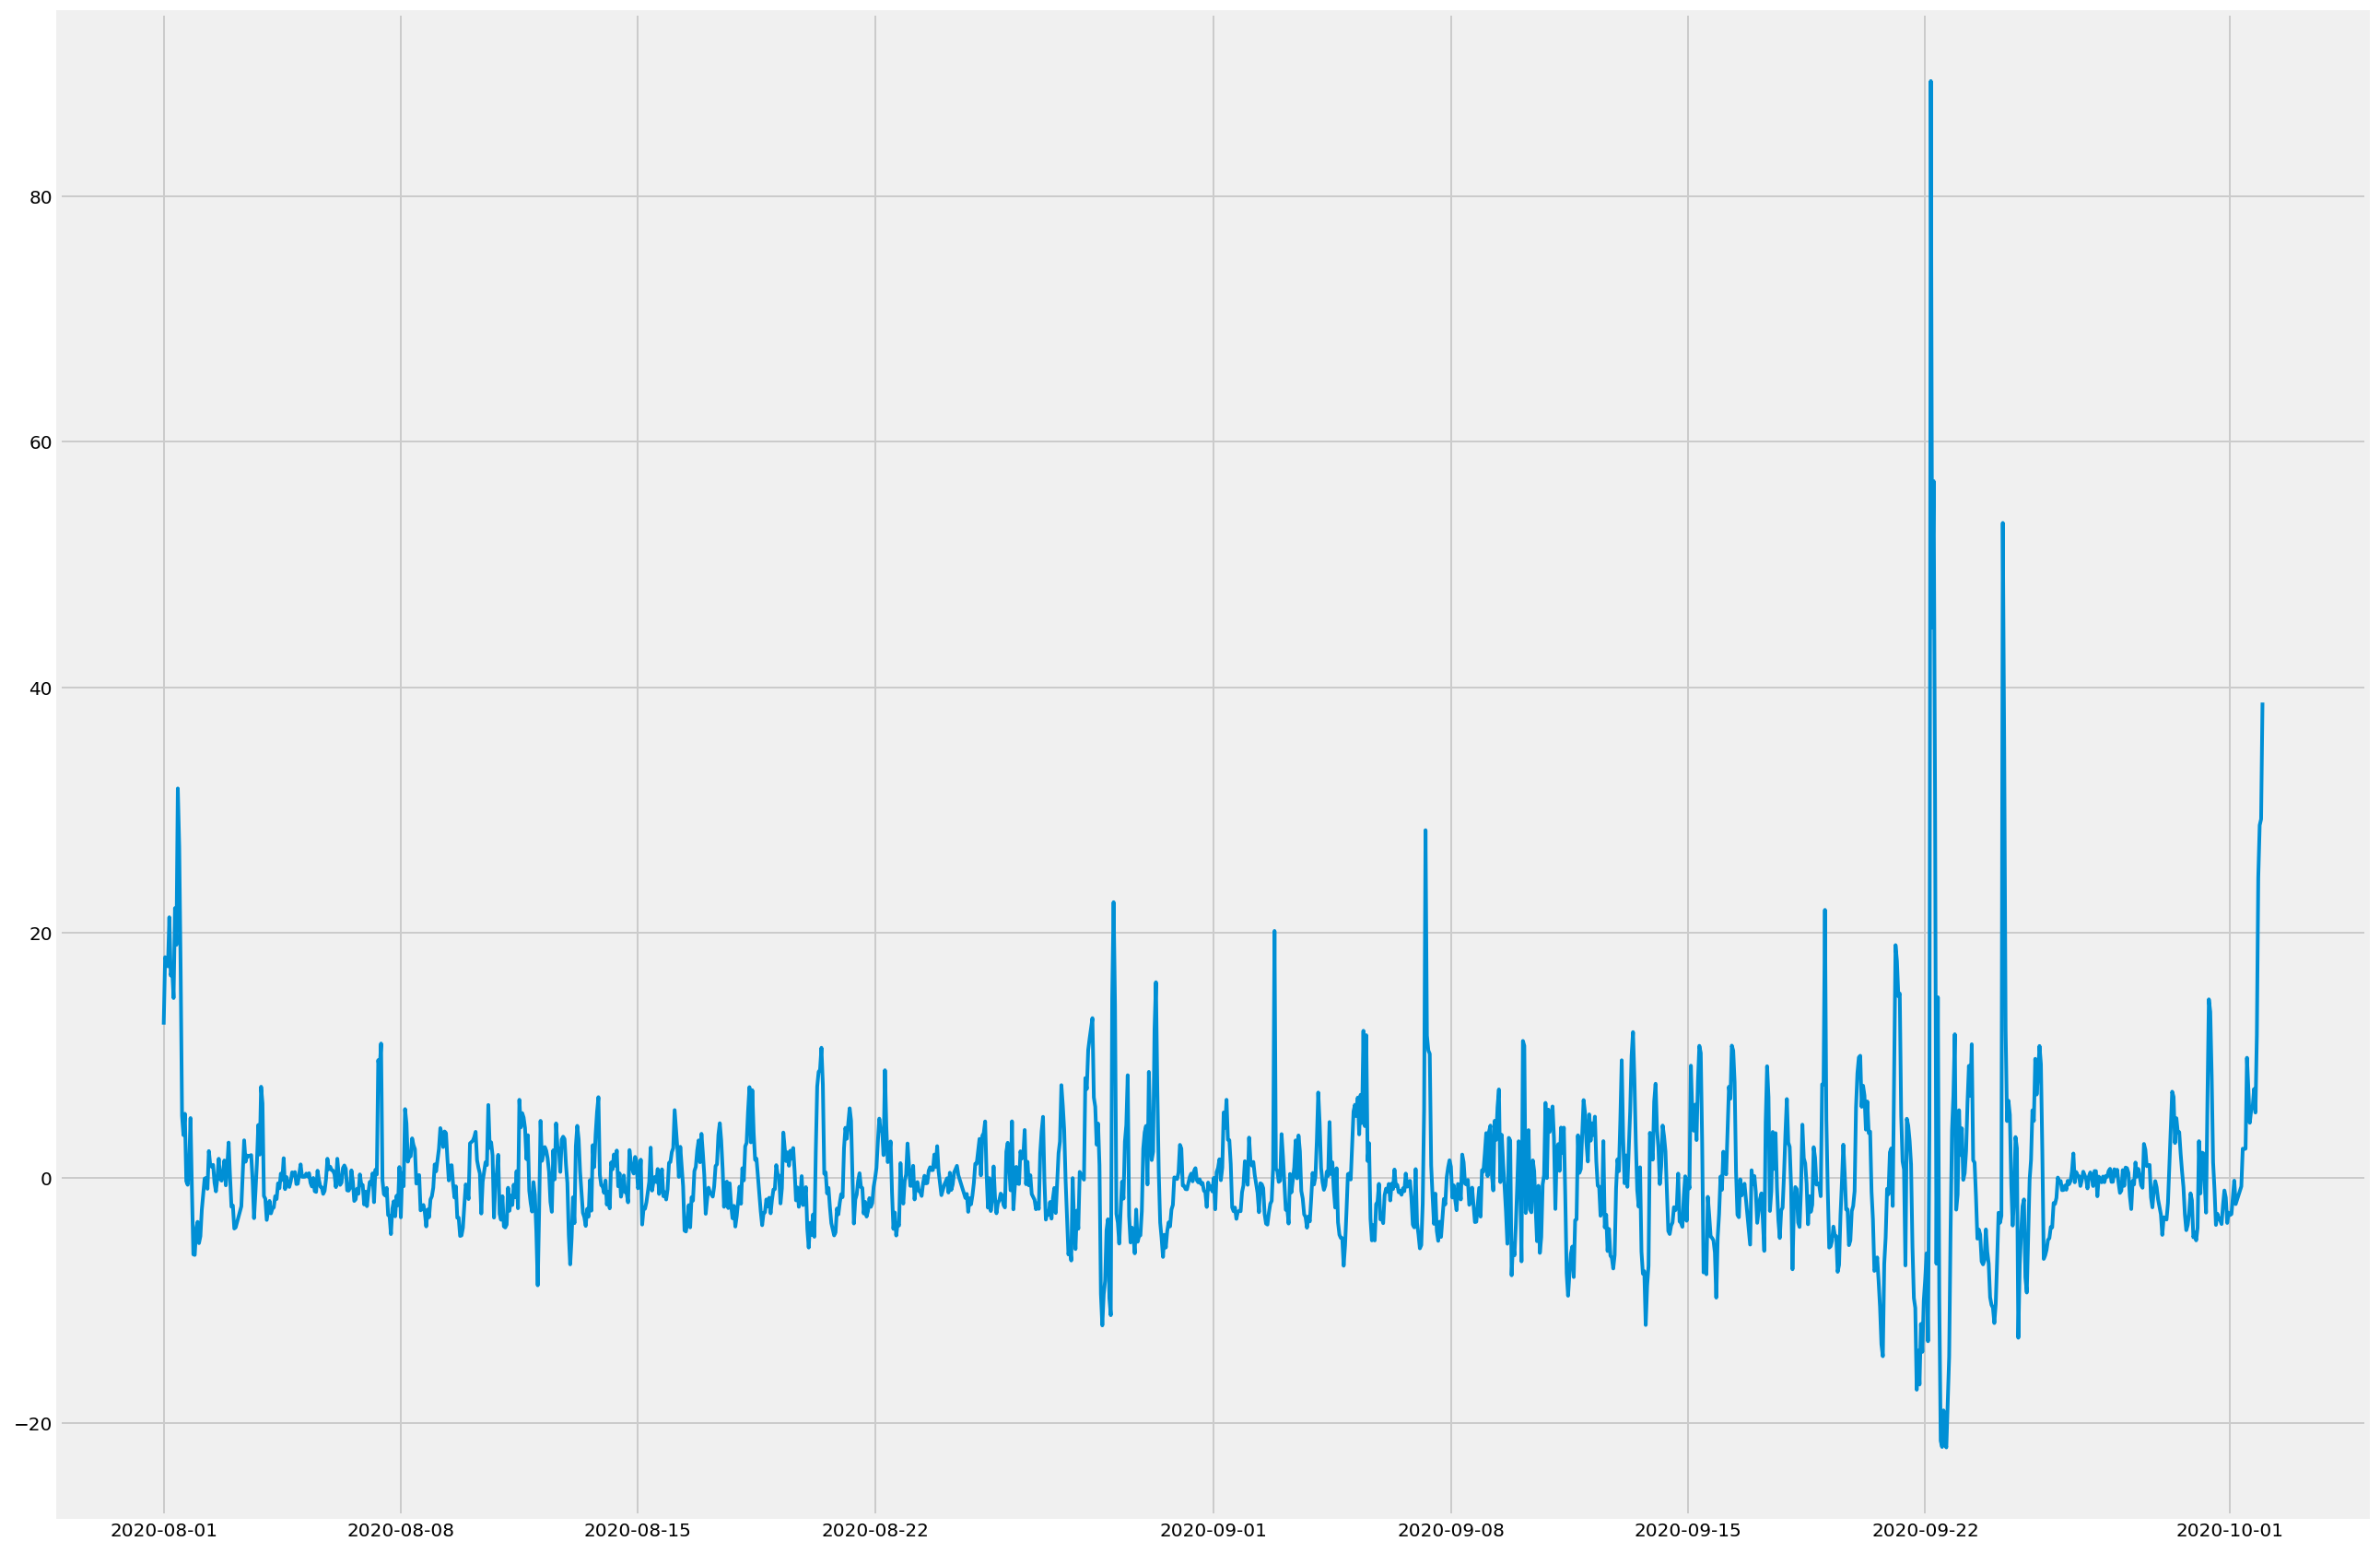

In [91]:
seasnoise = dati["pm2p5SPS"]["2020-08-01":"2020-10-01"].subtract(res.trend, fill_value=0)

plt.gcf().set_size_inches(20, 15)
plt.plot(seasnoise)
plt.show()

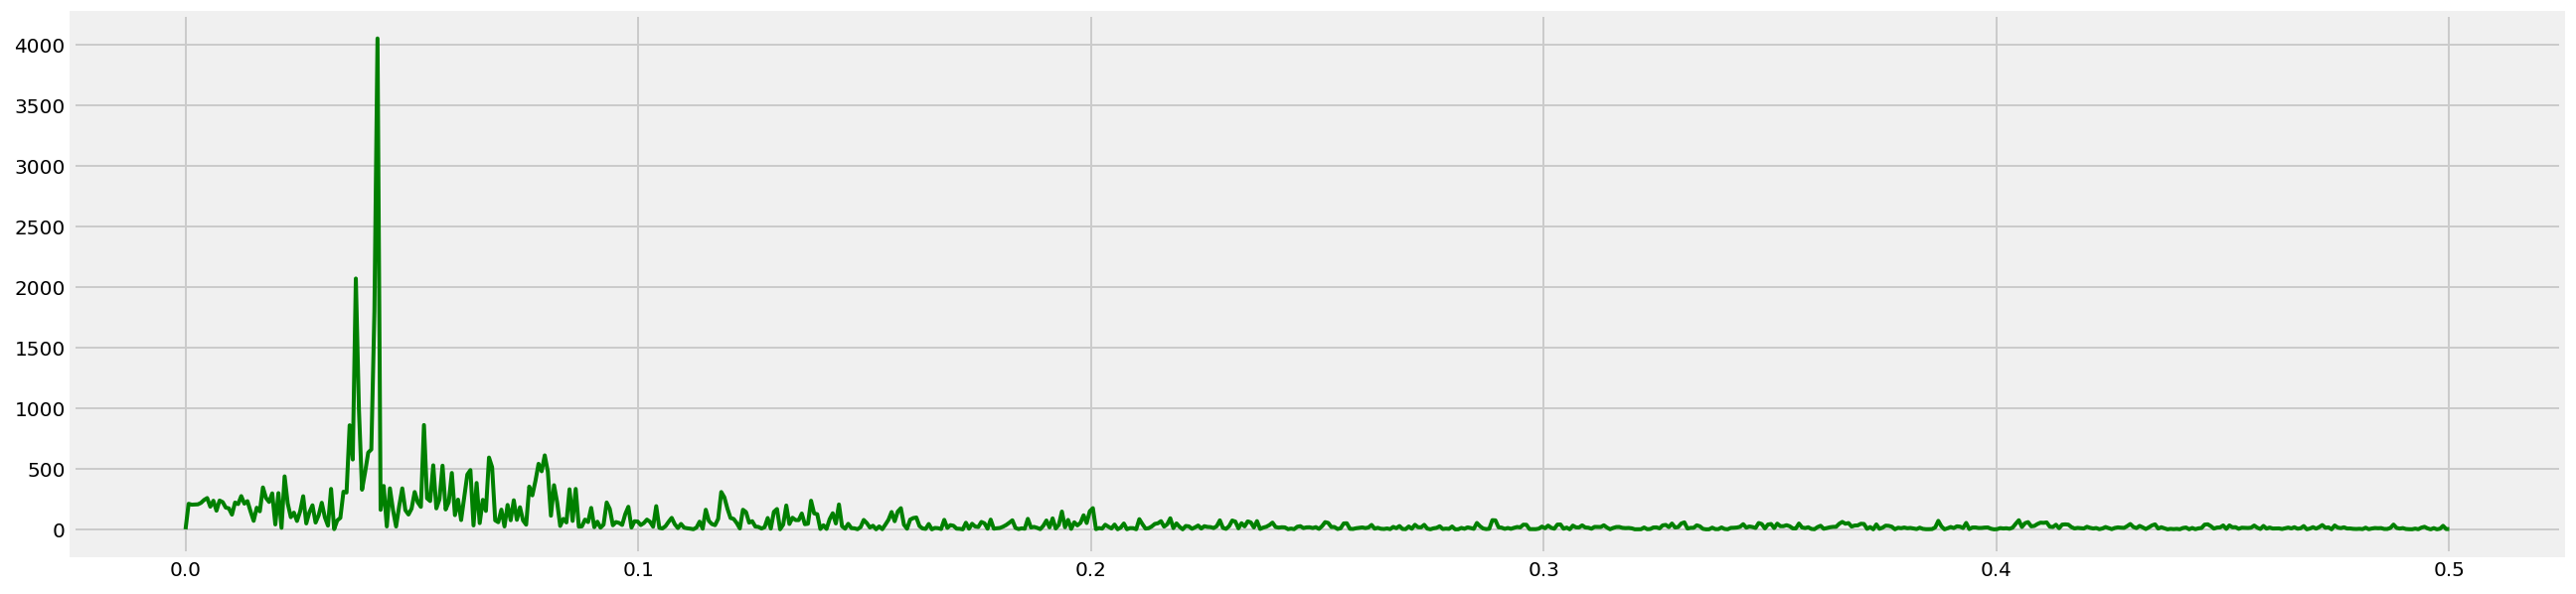

23.580645161290324


In [101]:
f, Pxx_den = sp.signal.periodogram(seasnoise)

plt.gcf().set_size_inches(20, 5)
plt.plot(f, Pxx_den, color="green")
plt.show()

print(1/f[np.argmax(Pxx_den)])

In [284]:
# distribution of missing values,
missing = {}

groupedData = averagedData.groupby('pot_id', as_index=False)

for potid, d in groupedData:
    missing[potid] = [potid, d["pm2p5SPS"].isna().sum(), len(d["pm2p5SPS"])]

missingDF = pd.DataFrame(missing.values(), columns=["pot_id", "missing", "total"])
missingDF["percentage"] = missingDF["missing"]/missingDF["total"]
missingDF = missingDF.sort_values("percentage", ascending=False)

missingDF

,pot_id,missing,total,percentage
65,1511,360,370,0.972973
66,1515,357,369,0.967480
67,1516,354,369,0.959350
69,1547,331,350,0.945714
68,1520,347,369,0.940379
...,...,...,...,...
24,1043,97,2935,0.033049
11,1020,83,3014,0.027538
5,1011,88,3203,0.027474
10,1018,54,3202,0.016864


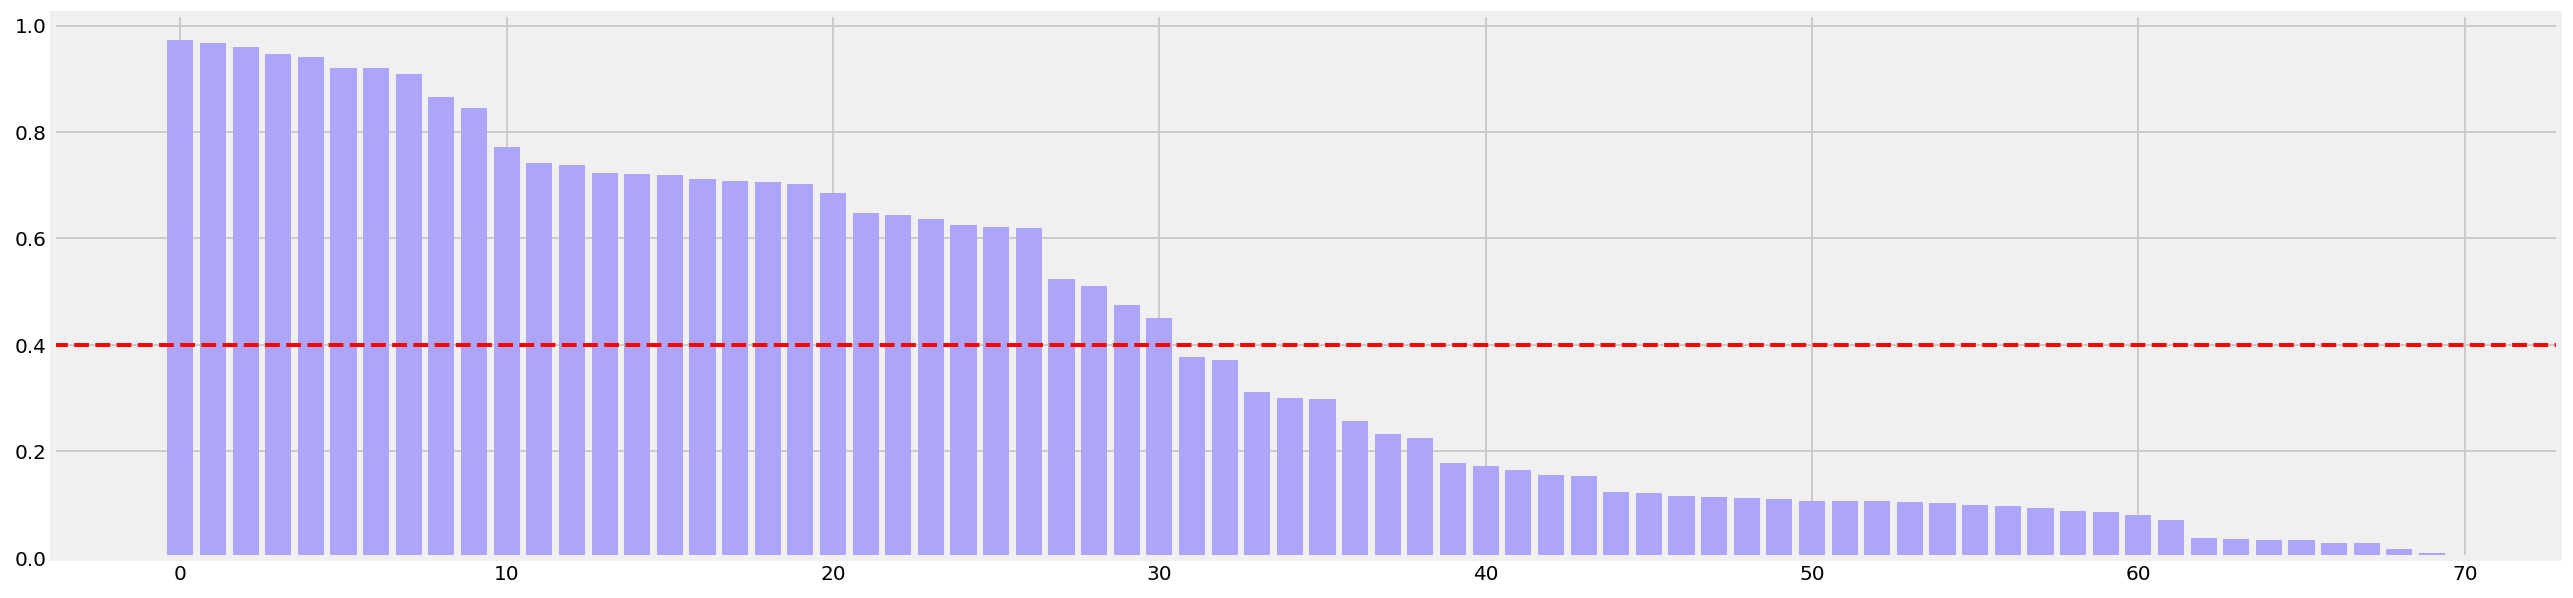

In [217]:
plt.gcf().set_size_inches(20, 5)
plt.bar(range(len(missingDF)), missingDF["percentage"], color="#ada5fa")
plt.axhline(y=0.4, color="red", linestyle='dashed')
plt.show()

In [219]:
# how many series have more than 40% missing values??
badSeries = len(missingDF.loc[missingDF["percentage"]>0.4])

print("number of sensors: " + str(badSeries))
print("percentage: " + str(badSeries/len(missingDF)) + "%")

number of sensors: 31
percentage: 0.44285714285714284%


In [260]:
# distribution of missing values in time
import calendar

minMonth = averagedData.index.min()
maxMonth = averagedData.index.max()

missingByMonth = pd.DataFrame(columns=["month", "percentage", "unique IDs"])

totMissing = averagedData["pm2p5SPS"].isna().sum()

for i in range(minMonth.month, maxMonth.month):
    tmp = averagedData.loc[averagedData.index.month == i]
    missingByMonth = missingByMonth.append({"month": calendar.month_name[i], 
                                            "percentage": tmp["pm2p5SPS"].isna().sum()/totMissing,
                                            "unique IDs": len(tmp["pot_id"].unique())},
                                          ignore_index = True)
    
missingByMonth

,month,percentage,unique IDs
0,June,0.010765,30
1,July,0.244644,62
2,August,0.313287,62
3,September,0.253314,64
4,October,0.164075,70


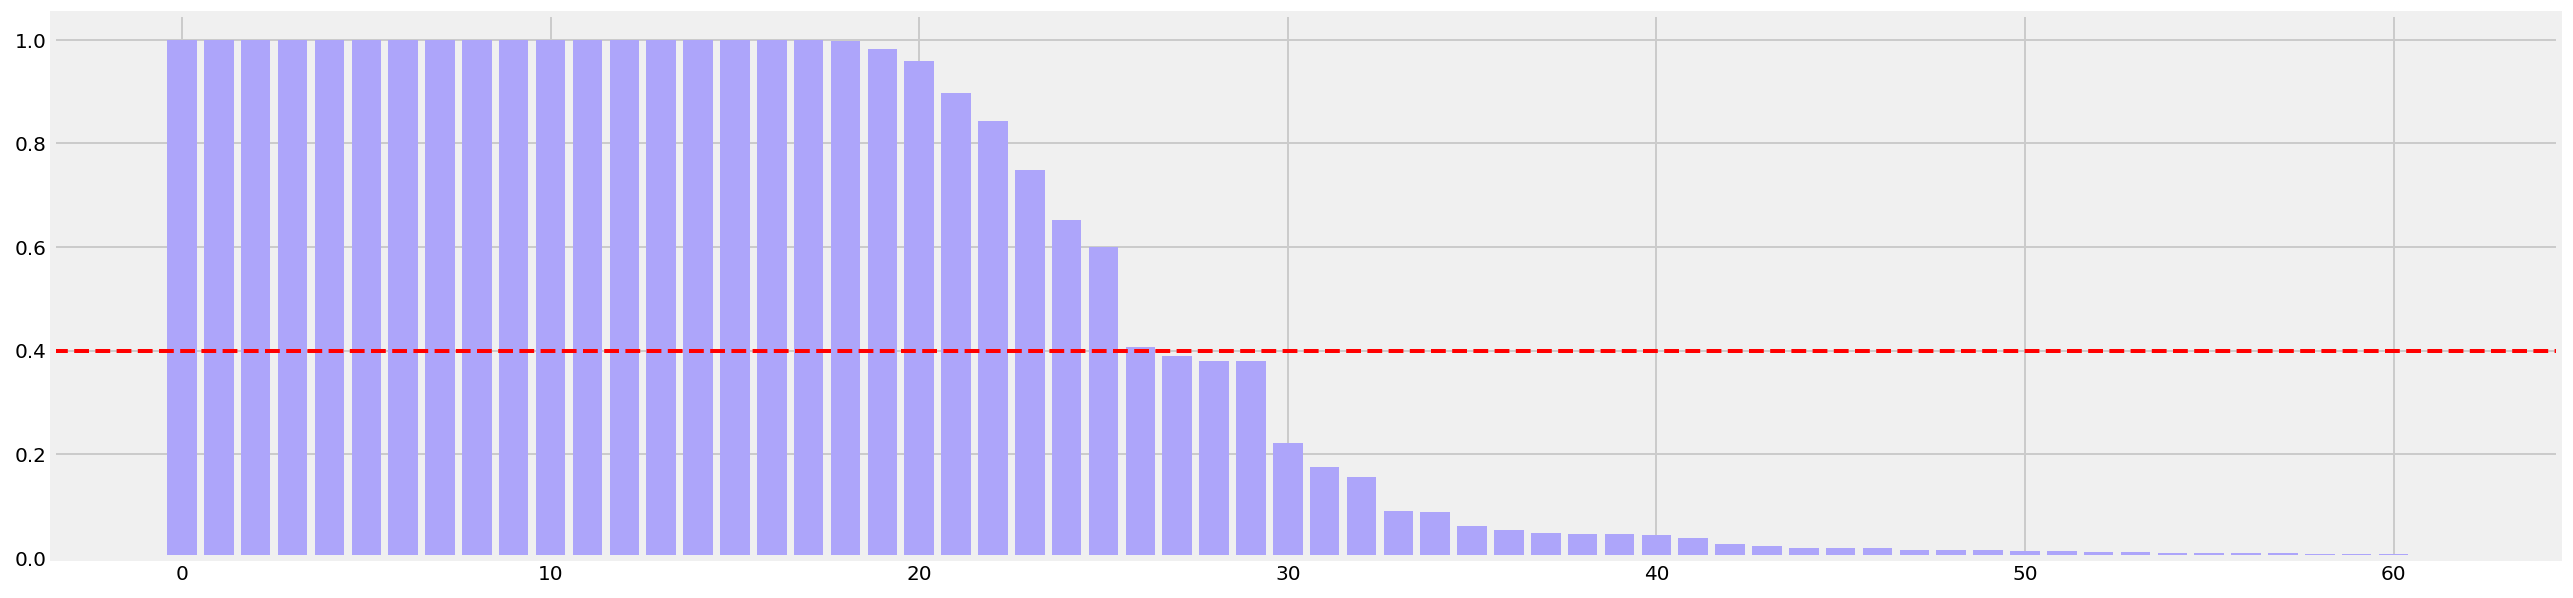

In [259]:
# August
missingAug = {}

groupedData = averagedData["2020-08-01":"2020-08-30"].groupby('pot_id', as_index=False)

for potid, d in groupedData:
    missingAug[potid] = [potid, d["pm2p5SPS"].isna().sum(), len(d["pm2p5SPS"])]

missingDFAug = pd.DataFrame(missingAug.values(), columns=["pot_id", "missing", "total"])
missingDFAug["percentage"] = missingDFAug["missing"]/missingDFAug["total"]
missingDFAug = missingDFAug.sort_values("percentage", ascending=False)

plt.gcf().set_size_inches(20, 5)
plt.bar(range(len(missingDFAug)), missingDFAug["percentage"], color="#ada5fa")
plt.axhline(y=0.4, color="red", linestyle='dashed')
plt.show()

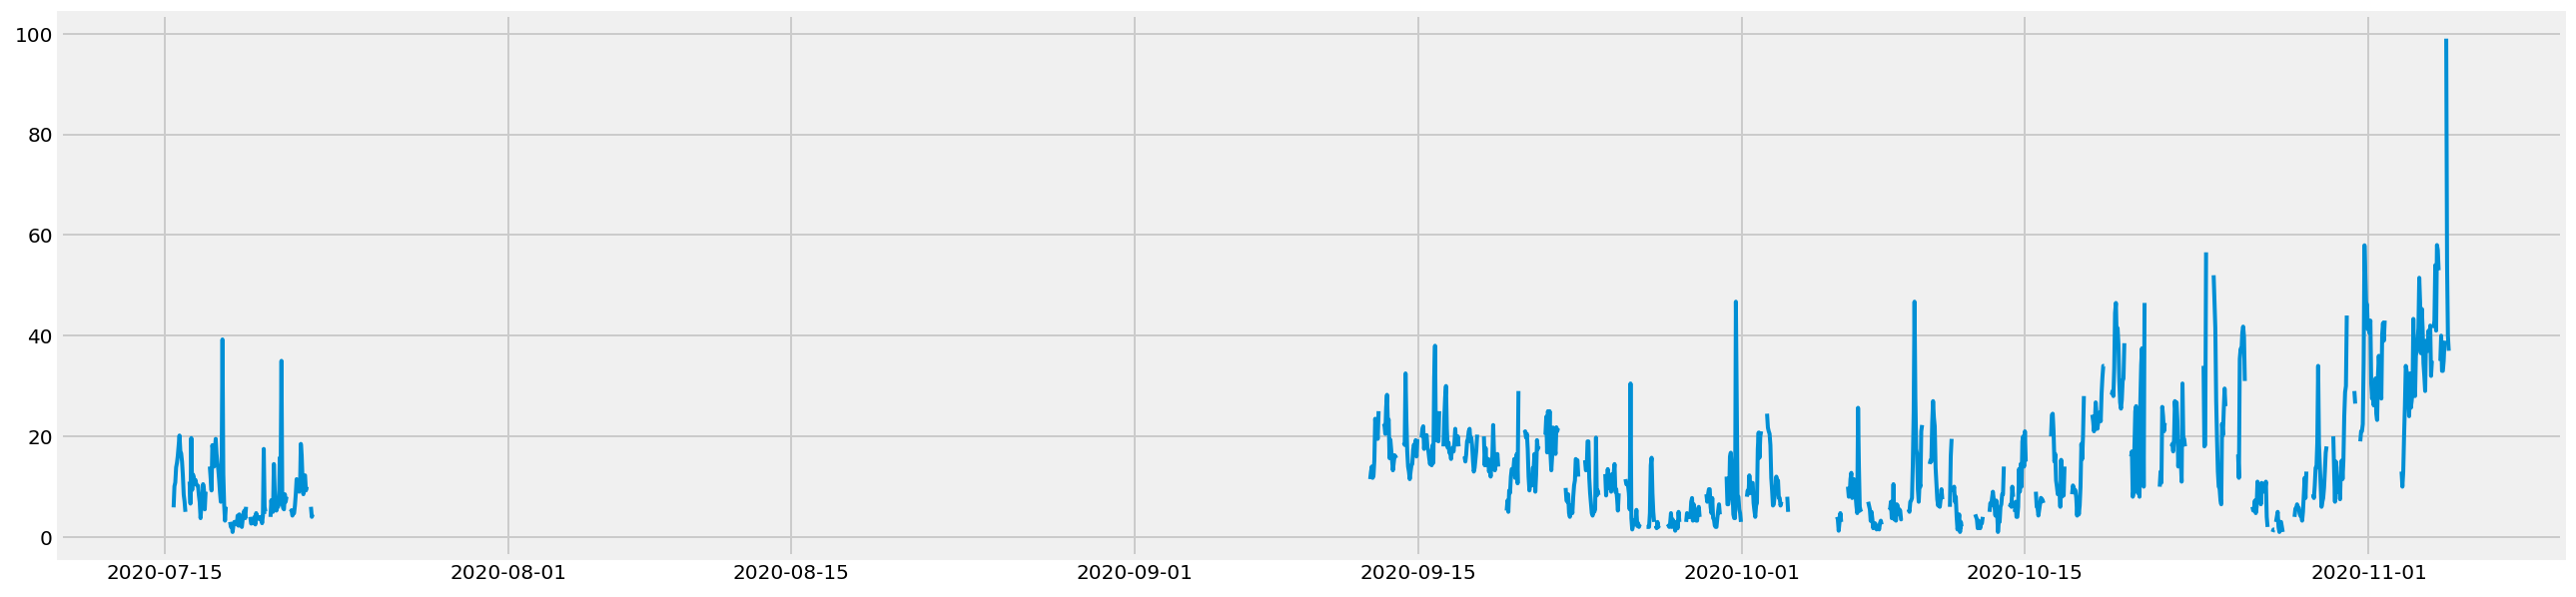

In [262]:
# serie da schifo, col 100% dei missing values ad agosto
plt.gcf().set_size_inches(20, 5)
plt.plot(averagedData.loc[averagedData["pot_id"]==1095]["pm2p5SPS"])
plt.show()

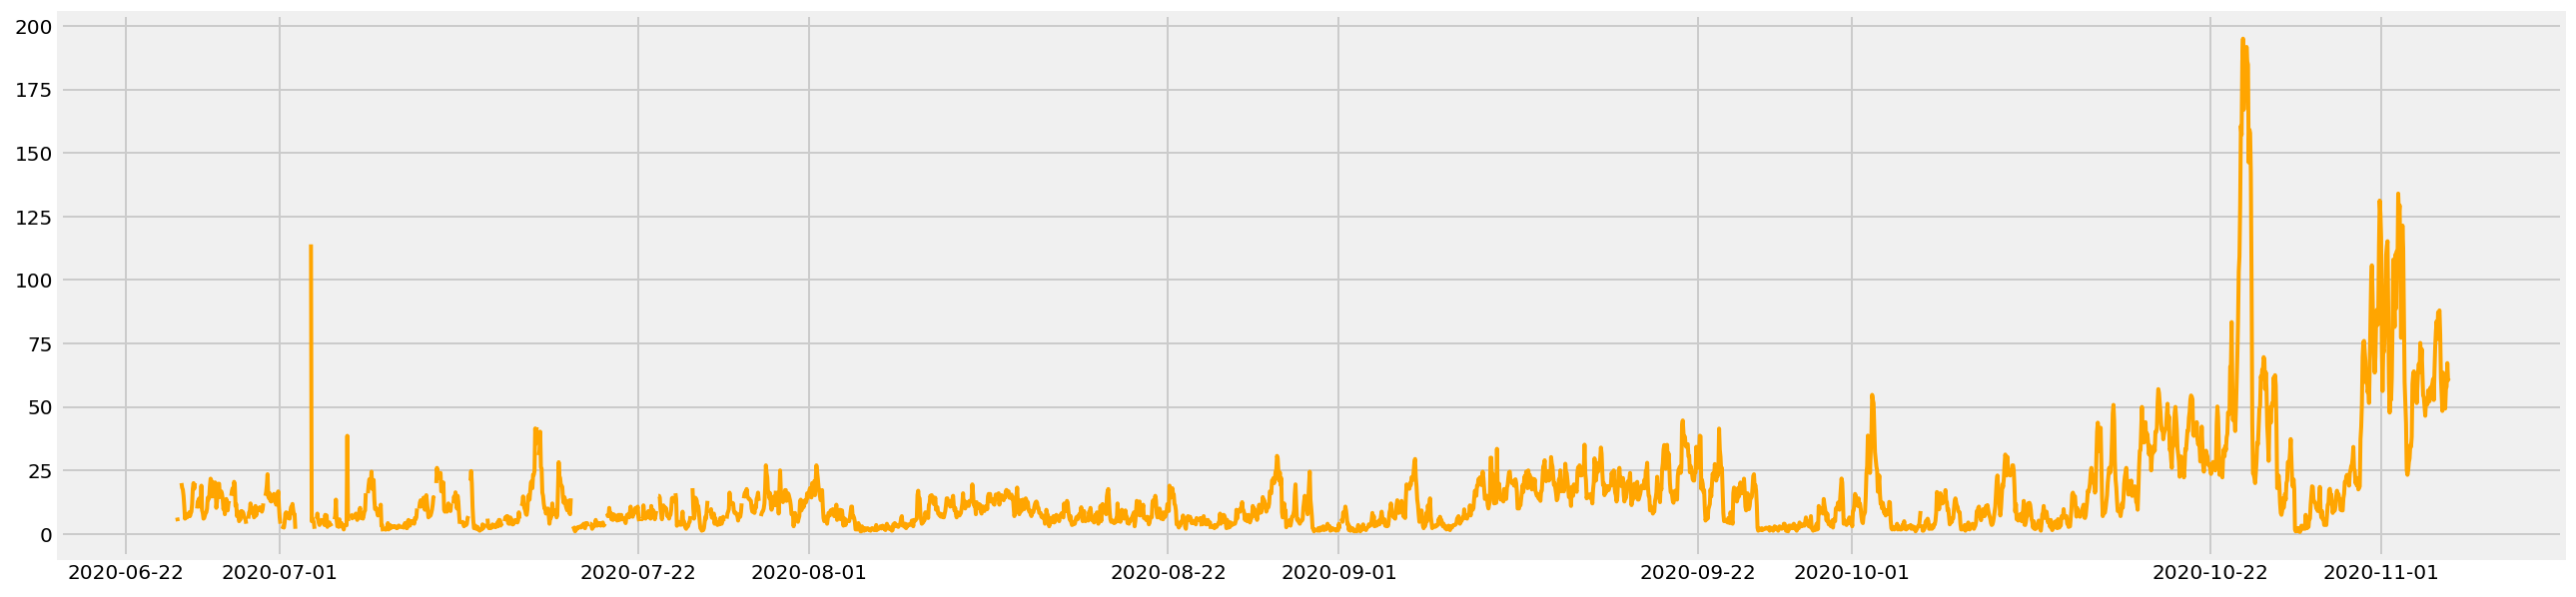

In [264]:
# serie bella
plt.gcf().set_size_inches(20, 5)
plt.plot(averagedData.loc[averagedData["pot_id"]==1034]["pm2p5SPS"], color="orange")
plt.show()

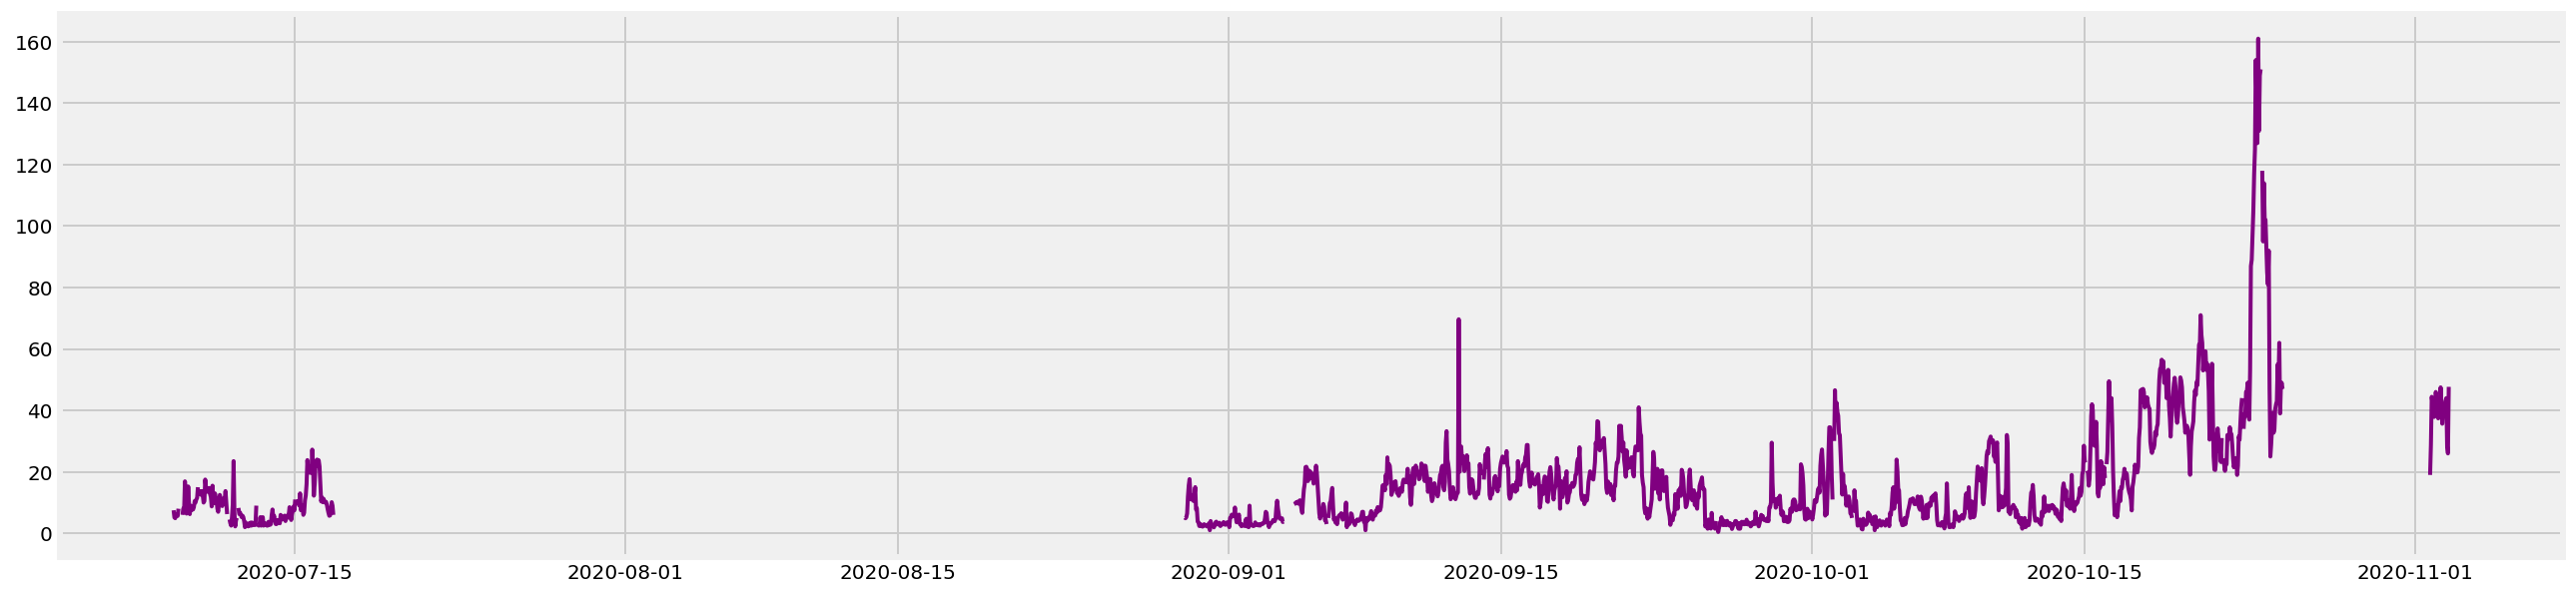

In [275]:
# serie col 44% di missing values
plt.gcf().set_size_inches(20, 5)
plt.plot(averagedData.loc[averagedData["pot_id"]==1068]["pm2p5SPS"], color="purple")
plt.show()

# non accettabile, perchè i missing values non sono equidistributi nel tempo...